In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, PyPlot, Statistics

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");
include("plotting_functions.jl");
# workspace()

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
processed_data = process_raw_params("../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv", pcp_source_params);

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


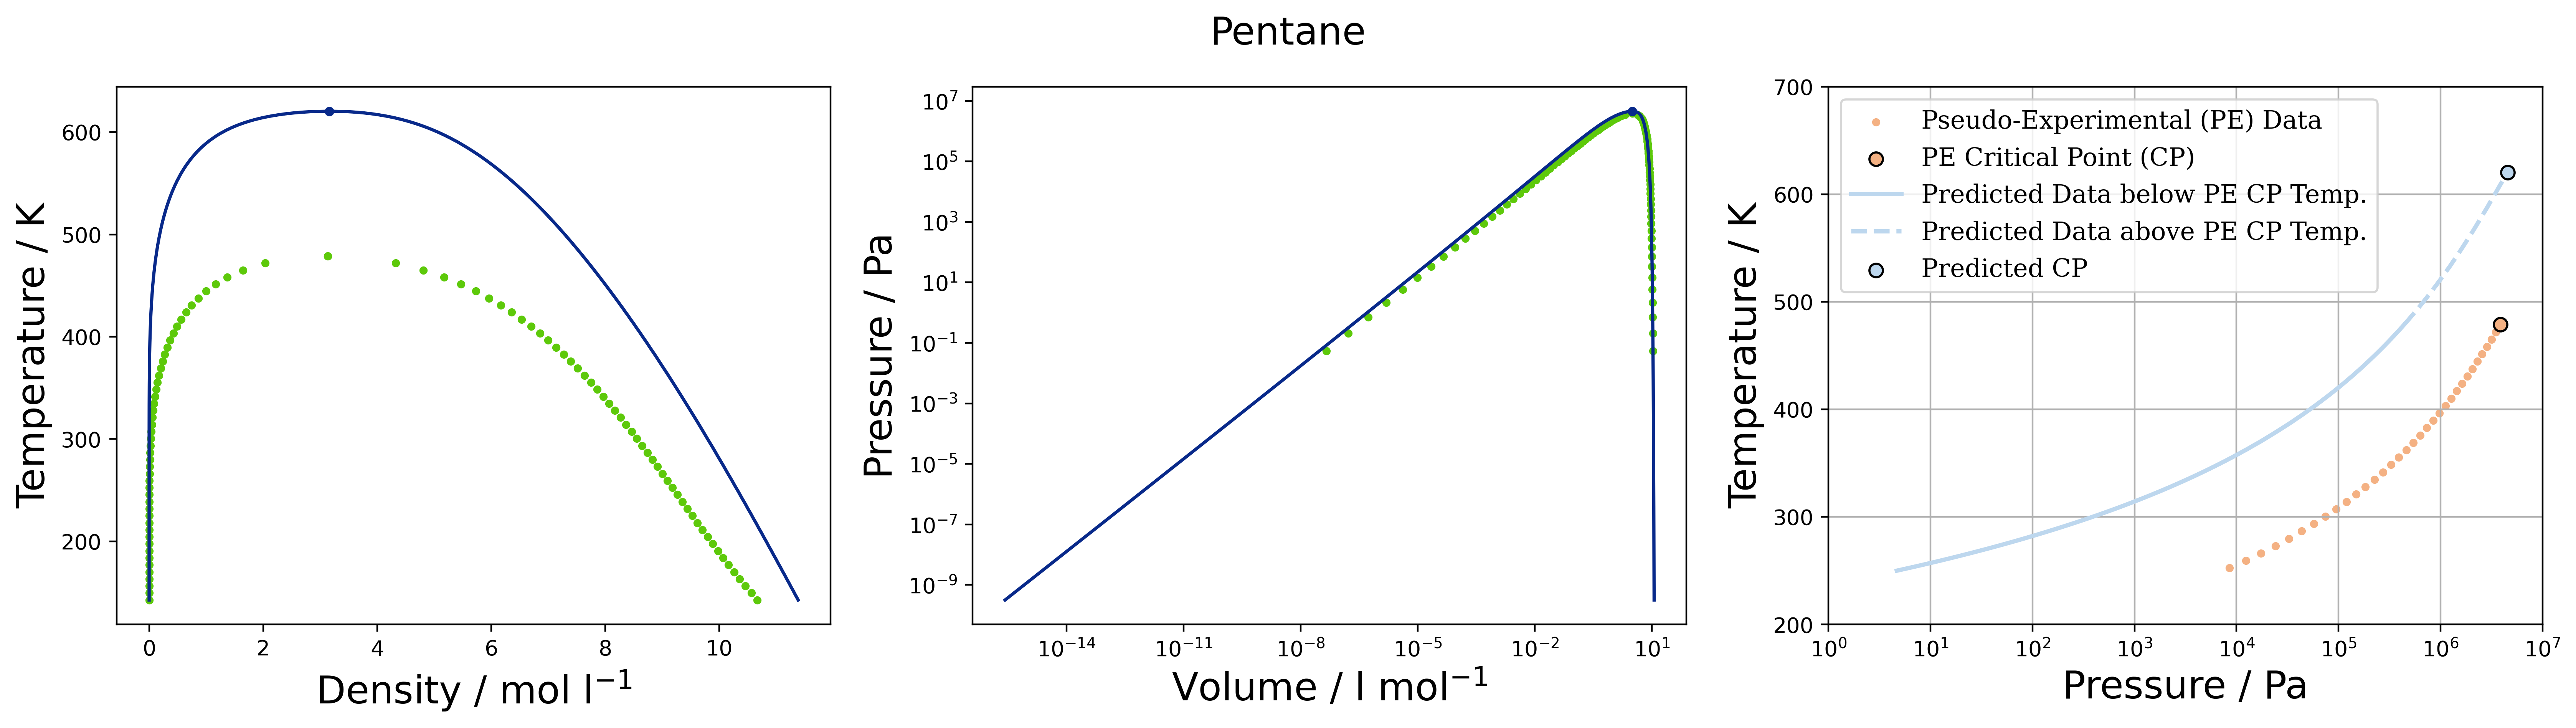

In [5]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)

test_species = "Pentane"
# test_species = "2,2,4,4,6,8,8-heptamethylnonane"

# set plotting properties
plot_all_exptl_data = true
second_deriv_props_p = 10^5
n_points_exptl = 50
same_temp_range = false
plot_dashed_above_crit = false
epoch = 1#length(processed_data[1,:m])
label_fontsize = 18
ticks_fontsize = 14
T_min_plot = 250

source_data_test_species = filter(row -> row.common_name == lowercase(test_species), pcp_source_params);
processed_data_split = processed_data #filter(row -> row.split == "val", processed_data)

# obtain plotting data
T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(test_species), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points_exptl, same_temp_range=same_temp_range)
T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(test_species), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)

if plot_all_exptl_data == true
    pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
    pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
    pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
else
    pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
    pcp_T_plot_cc = T_range_pcp
    pcp_P_plot_cc = p_range_pcp
end

vrmie_rho_plot = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie))
vrmie_T_plot = vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie))
vrmie_P_plot = vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie))
vrmie_rho_plot_liq = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3])
vrmie_rho_plot_vap = 1e-3 ./v_vap_range_vrmie



figure_1, axes_1 = plt.subplots(1,3, figsize=(17, 5), dpi=400)
figure_1.suptitle(test_species, fontsize=18,y=0.95)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=ticks_fontsize)

# Axes 1
axes_1[1].scatter(pcp_rho_plot, pcp_T_plot_envelope, color="#5dc90a",s=8)
axes_1[1].scatter(1e-3/vrmie_crits[3], vrmie_crits[1], color="#08298a",s=12)

if plot_dashed_above_crit == true
    
    index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
    
    axes_1[1].plot(vrmie_rho_plot_liq[1:index_cutoff-1], vcat(T_range_vrmie, vrmie_crits[1])[1:index_cutoff-1],color="#08298a")
    axes_1[1].plot(vrmie_rho_plot_liq[index_cutoff:end], vcat(T_range_vrmie, vrmie_crits[1])[index_cutoff:end],color="#08298a","--")

    axes_1[1].plot(vrmie_rho_plot_vap[1:index_cutoff-1], T_range_vrmie[1:index_cutoff-1],color="#08298a")
    axes_1[1].plot(vrmie_rho_plot_vap[index_cutoff:end], T_range_vrmie[index_cutoff:end],color="#08298a","--")

else

    axes_1[1].plot(vrmie_rho_plot, vrmie_T_plot,color="#08298a")

end

axes_1[2].scatter(pcp_rho_plot, pcp_P_plot_envelope, color="#5dc90a",s=8)
axes_1[2].scatter(1e-3 /vrmie_crits[3], vrmie_crits[2], color="#08298a",s=12)
axes_1[2].loglog(vrmie_rho_plot, vrmie_P_plot ,color="#08298a")

index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
index_cutoff_T_min_vrmie = argmin(abs.(T_range_vrmie .- T_min_plot))
index_cutoff_T_min_pcp = argmin(abs.(pcp_T_plot_cc .- T_min_plot))

# axes_1[3].axhline(0.95*pcp_crits[1], color="black", linestyle="--", label="Horizontal Line")
axes_1[3].scatter(pcp_P_plot_cc[index_cutoff_T_min_pcp:end], pcp_T_plot_cc[index_cutoff_T_min_pcp:end], color="#F4B183",s=8)
axes_1[3].scatter(pcp_crits[2], pcp_crits[1], color="#F4B183",s=40,edgecolors="black")

axes_1[3].plot(p_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], T_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], color="#BDD7EE",linewidth=2)
axes_1[3].plot(p_range_vrmie[index_cutoff_crit:end], T_range_vrmie[index_cutoff_crit:end], color="#BDD7EE",linewidth=2,"--")
axes_1[3].scatter(vrmie_crits[2], vrmie_crits[1], color="#BDD7EE",s=40,edgecolors="black")


# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2],ticks_fontsize = 14)
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[1].set_ylim([150,400])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[1].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$",fontsize=label_fontsize)
axes_1[1].set_ylabel("Temperature / K",fontsize=label_fontsize)

# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[2].set_ylim([10^-10,10^12])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[2].set_xlabel(L"Volume / l mol$\mathregular{^{-1}}$",fontsize=label_fontsize)
axes_1[2].set_ylabel("Pressure / Pa",fontsize=label_fontsize)
# axes_1[2].legend(["Pseudo-Experimental Data","Predicted Critical Point","Predicted Point"],loc="upper left")


axes_1[3].set_xscale("log")
# axes_1[2].set_xtickslabel(e)
axes_1[3].set_xticks([10^0, 10^1, 10^2, 10^3, 10^4, 10^5, 10^6, 10^7])
axes_1[3].set_xlim([10^0,10^7])
axes_1[3].set_ylim([200,700])
axes_1[3].set_ylabel("Temperature / K",fontsize=label_fontsize)
axes_1[3].set_xlabel("Pressure / Pa",fontsize=label_fontsize)
axes_1[3].grid("on")
axes_1[3].legend(["Pseudo-Experimental (PE) Data","PE Critical Point (CP)","Predicted Data below PE CP Temp.","Predicted Data above PE CP Temp.","Predicted CP"],fontsize=11.75)
# axes_1[3].legend(["0.95 Pseudo-Experimental Critical Point"],fontsize=12, loc="upper left")


tight_layout()

In [5]:
runs_main_dir = readdir("../jobs/24_long_scripts")
target_fold_directories = filter(dir -> contains(dir, "5_clip_points_s"), runs_main_dir)

println(target_fold_directories)

files_for_val_training = []
files_for_val_error = []

for i in target_fold_directories

    push!(files_for_val_training, "../jobs/24_long_scripts/$i/params_log.csv")

    error_log_files = filter(dir -> contains(dir, ".o"), readdir("../jobs/24_long_scripts/$i"))
    push!(files_for_val_error, "../jobs/24_long_scripts/$i/$(error_log_files[end])")

end

println(length(files_for_val_training))
println(length(files_for_val_error))

["5_clip_points_strat1", "5_clip_points_strat2", "5_clip_points_strat3", "5_clip_points_strat4", "5_clip_points_strat5"]
5
5


In [6]:
files_to_average = [1,2,3,4,5]
line_start_main_training = 7007

epochs_min_val_loss, total_epochs, average_val_loss, average_train_loss, average_epoch_time = readout_file_analysis(files_for_val_error=files_for_val_error, line_start_main_training=line_start_main_training,files_to_average=files_to_average)

@show epochs_min_val_loss
@show total_epochs;
# @show average_val_loss

[1787, 2774, 2462, 2004, 2043]
epochs_min_val_loss = 27
total_epochs = [1787, 2774, 2462, 2004, 2043]


620


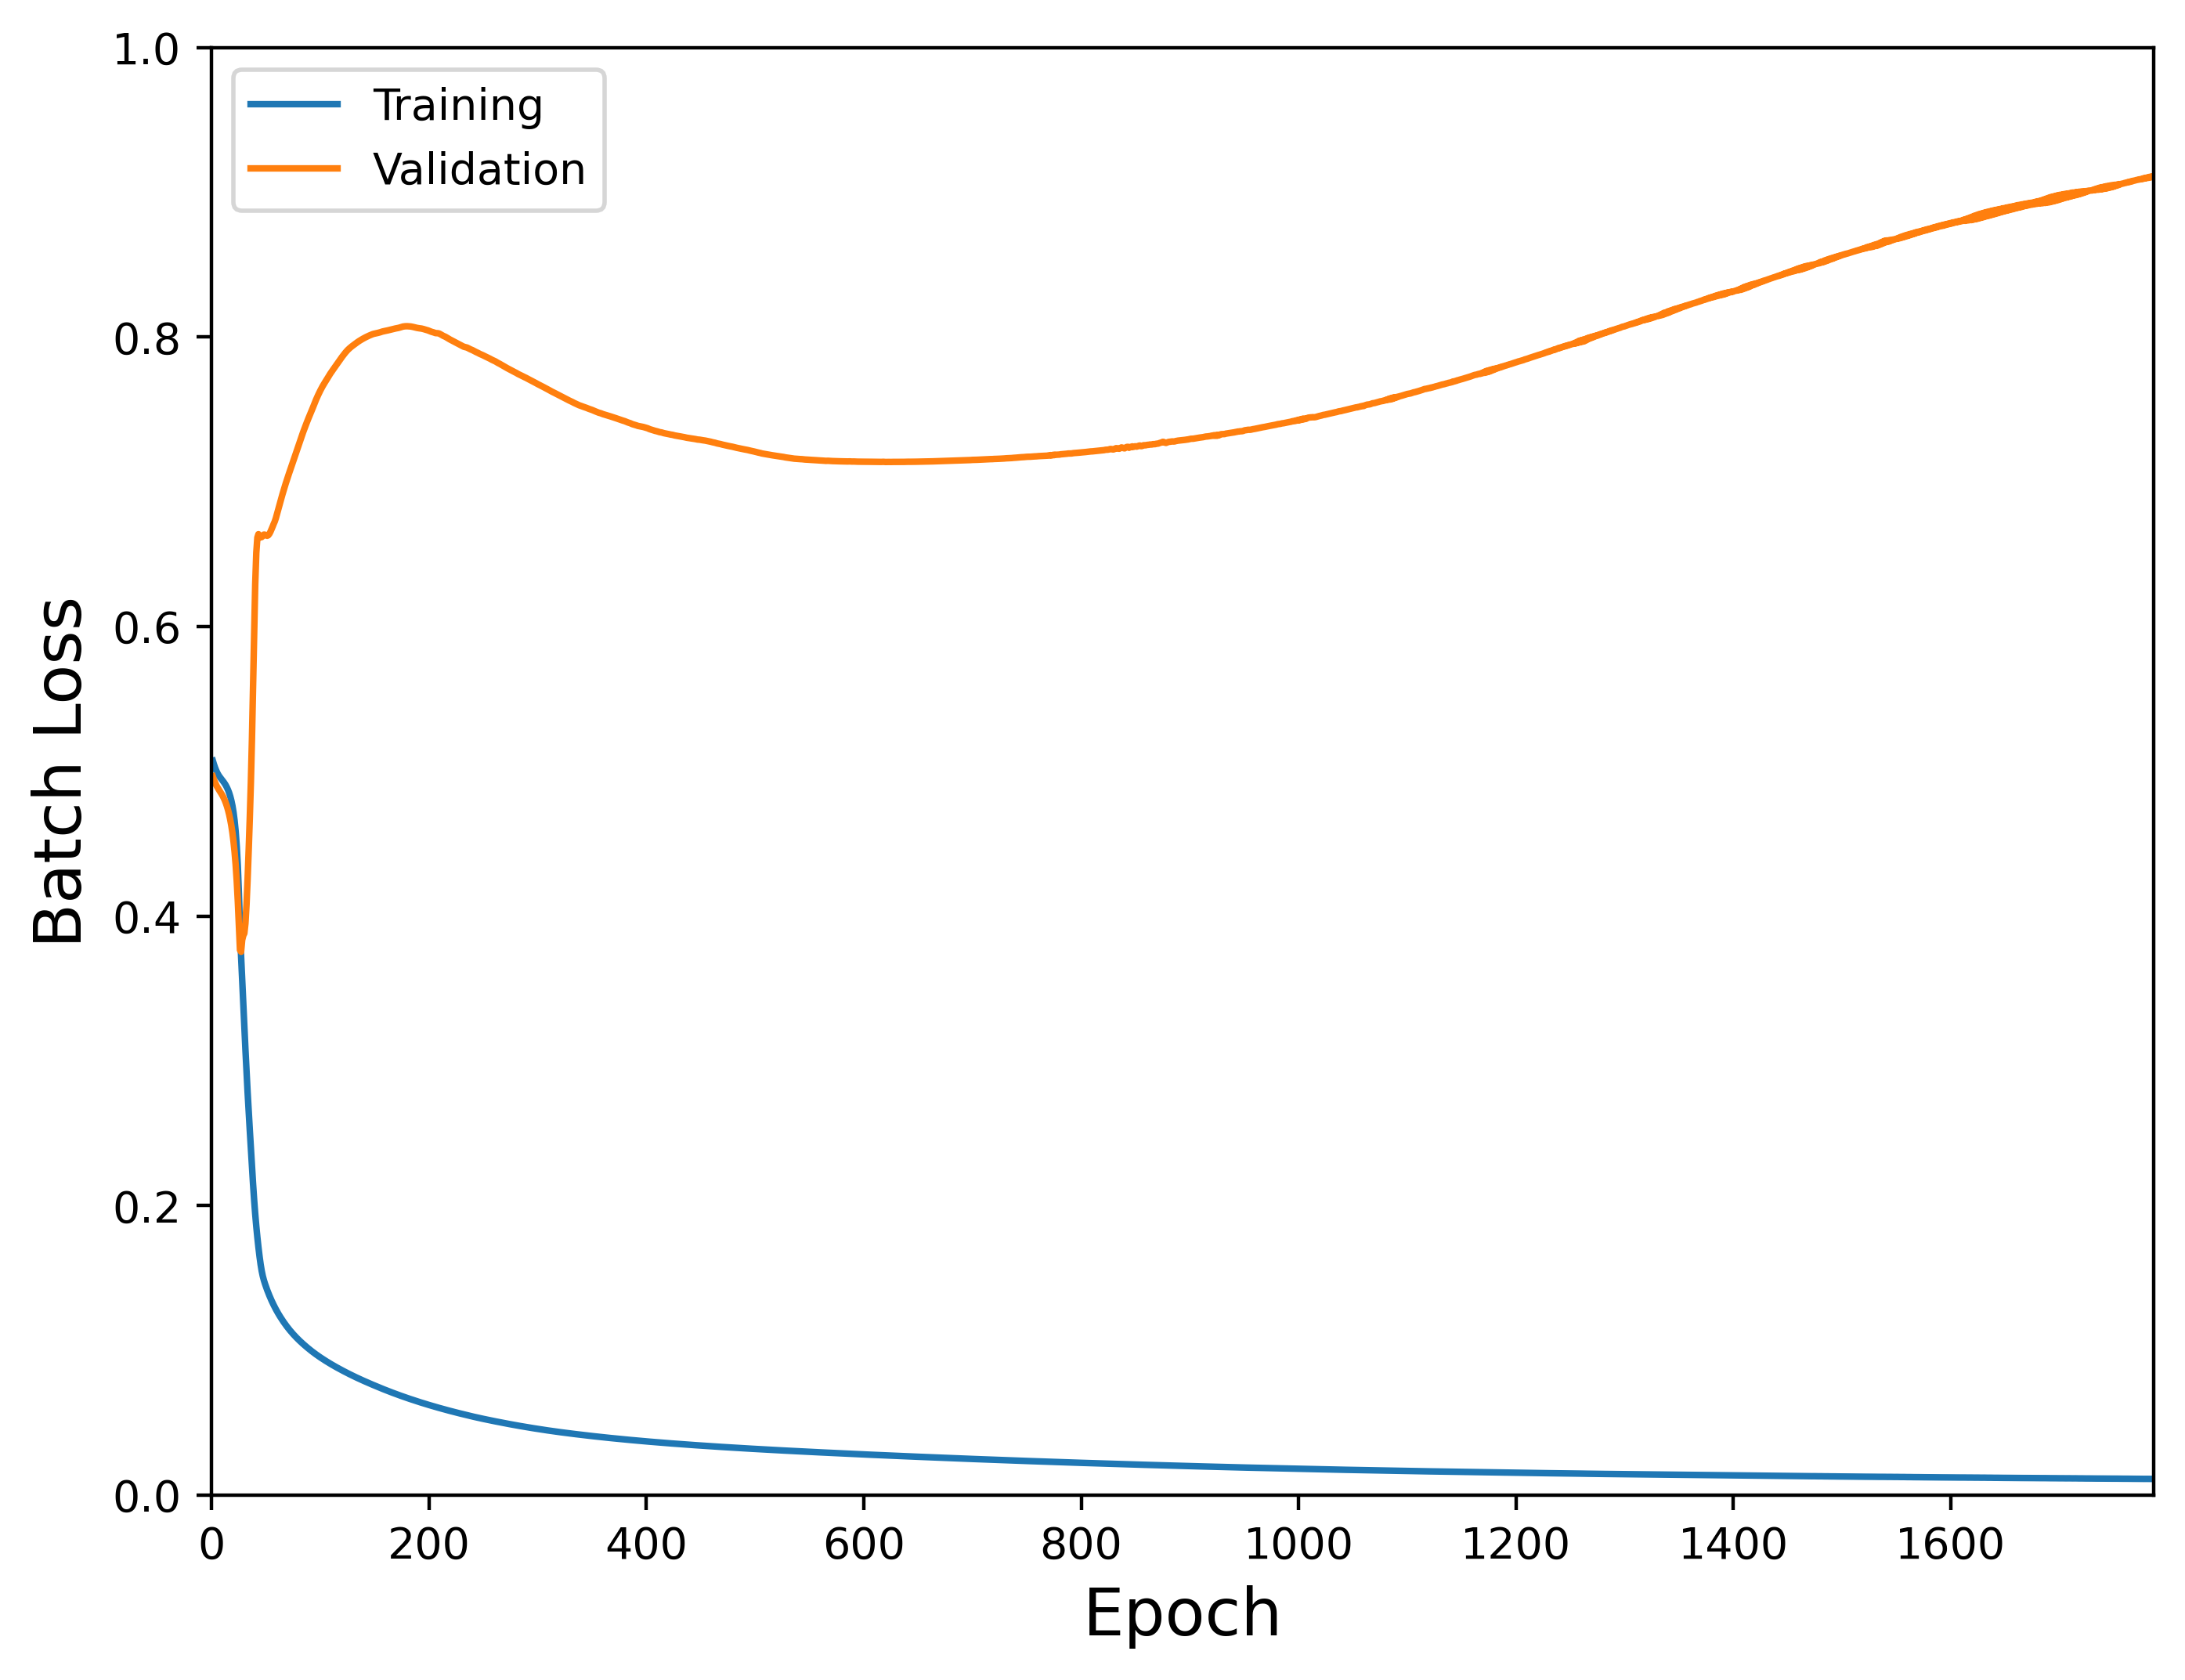

In [7]:
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 6), dpi=400)

value_ignored = 60 # use this to set the epoch range for plot

axes2.plot(1:minimum(total_epochs[(total_epochs .!= value_ignored)]), average_train_loss)
axes2.plot(1:minimum(total_epochs[(total_epochs .!= value_ignored)]), average_val_loss)

axes2.set_xlabel("Epoch", fontsize=15)
axes2.set_ylabel("Batch Loss", fontsize=15)
axes2.set_xlim([0,minimum(total_epochs[(total_epochs .!= value_ignored)])])
axes2.legend(["Training","Validation"],loc="upper left")
axes2.set_ylim([0,1])

epoch_min_late = argmin(abs.(average_val_loss[100:end] .- minimum(average_val_loss[100:end])))
println(epoch_min_late + 99)

In [8]:
files_for_val_training_trimmed = [files_for_val_training[i] for i in files_to_average]

string_arrays_dict = Dict{Int, Vector{String}}()
processed_data_storage = []

keys_string_dict = 1:length(files_for_val_training_trimmed)

for (key, path) in zip(keys_string_dict,files_for_val_training_trimmed)
        
        processed_data = process_raw_params(path, pcp_source_params)

        processed_data_split = filter(row -> row.split == "val", processed_data)

        push!(processed_data_storage, processed_data_split)

        string_arrays_dict[key] = processed_data_split.species

end

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ 

In [10]:
analyse_training = false

epoch = 1787 #true #620 # min(total_epochs) (shortest of all five folds), true (max length each fold)
n_points = 50

# Specify the range of experimental data to be plotted
plot_all_exptl_data = false
same_temp_range = true

# Computed data properties
second_deriv_props_p = 10^4


species_list = string.(vcat(collect(processed_data_storage[i][!,:species] for i = 1:length(files_to_average))...))

num_rows = length(species_list)

val_data_summary_APD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    APD_vsat_l = fill(0.0, num_rows),
    APD_vsat_v = fill(0.0, num_rows),
    APD_rhosat_l = fill(0.0, num_rows),
    APD_rhosat_v = fill(0.0, num_rows),
    APD_psat = fill(0.0, num_rows),
    APD_cp = fill(0.0, num_rows),
    APD_cv = fill(0.0, num_rows),
    APD_speed_sound = fill(0.0, num_rows),
) ;

val_data_summary_AAD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    AAD_vsat_l = fill(0.0, num_rows),
    AAD_vsat_v = fill(0.0, num_rows),
    AAD_rhosat_l = fill(0.0, num_rows),
    AAD_rhosat_v = fill(0.0, num_rows),
    AAD_psat = fill(0.0, num_rows),
    AAD_cp = fill(0.0, num_rows),
    AAD_cv = fill(0.0, num_rows),
    AAD_speed_sound = fill(0.0, num_rows),
) ;

row_counter_data_gen = 1

for i = 1:length(species_list)

    println(species_list[i])

    if analyse_training == true
        processed_data_split = processed_data_storage[Int(floor((i-1)/64) + 1)]
    else
    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species_list[i]))
    processed_data_split = processed_data_storage[key_i]
    end

    if epoch == true
        epoch = length(processed_data_storage[key_i][!,:m][1])
    end

    source_data_test_species = filter(row -> row.common_name == lowercase(species_list[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp, cv_range_pcp, speed_sound_range_pcp = sat_props_calc_PCP(species=lowercase(species_list[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie, cv_range_vrmie, speed_sound_range_vrmie = sat_props_calc_VrMie(species=lowercase(species_list[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, n_points=n_points, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
    v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
    p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
    cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)
    cv_range_pcp, cv_range_vrmie = remove_nans(cv_range_pcp, cv_range_vrmie)
    speed_sound_range_pcp, speed_sound_range_vrmie = remove_nans(speed_sound_range_pcp, speed_sound_range_vrmie)

    rho_liq_range_pcp = 1 ./v_liq_range_pcp
    rho_liq_range_vrmie = 1 ./v_liq_range_vrmie

    rho_vap_range_pcp = 1 ./v_vap_range_pcp
    rho_vap_range_vrmie = 1 ./v_vap_range_vrmie

    v_sat_l_APD = average_percentage_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_APD = average_percentage_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    rho_sat_l_APD = average_percentage_deviation(rho_liq_range_vrmie, rho_liq_range_pcp)
    rho_sat_v_APD = average_percentage_deviation(rho_vap_range_vrmie, rho_vap_range_pcp)
    p_sat_APD = average_percentage_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_APD = average_percentage_deviation(cp_range_vrmie, cp_range_pcp)
    cv_sat_APD = average_percentage_deviation(cv_range_vrmie, cv_range_pcp)
    speed_sound_APD = average_percentage_deviation(speed_sound_range_vrmie, speed_sound_range_pcp)

    v_sat_l_AAD = average_absolute_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_AAD = average_absolute_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    rho_sat_l_AAD = average_absolute_deviation(rho_liq_range_vrmie, rho_liq_range_pcp)
    rho_sat_v_AAD = average_absolute_deviation(rho_vap_range_vrmie, rho_vap_range_pcp)
    p_sat_AAD = average_absolute_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_AAD = average_absolute_deviation(cp_range_vrmie, cp_range_pcp)
    cv_sat_AAD = average_absolute_deviation(cv_range_vrmie, cv_range_pcp)
    speed_sound_AAD = average_absolute_deviation(speed_sound_range_vrmie, speed_sound_range_pcp)

    processed_data_test_species = filter(row -> row.species == lowercase(species_list[i]), processed_data_split);

    val_data_summary_APD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_APD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_APD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_l] = v_sat_l_APD
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_v] = v_sat_v_APD
    val_data_summary_APD[row_counter_data_gen,:APD_rhosat_l] = rho_sat_l_APD
    val_data_summary_APD[row_counter_data_gen,:APD_rhosat_v] = rho_sat_v_APD
    val_data_summary_APD[row_counter_data_gen,:APD_psat] = p_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_cp] = cp_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_cv] = cv_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_speed_sound] = speed_sound_APD

    val_data_summary_AAD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_AAD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_AAD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_l] = v_sat_l_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_v] = v_sat_v_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_rhosat_l] = rho_sat_l_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_rhosat_v] = rho_sat_v_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_psat] = p_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_cp] = cp_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_cv] = cv_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_speed_sound] = speed_sound_AAD

    row_counter_data_gen += 1
            
end

val_data_summary_APD = sort(val_data_summary_APD, :Mw);
val_data_summary_AAD = sort(val_data_summary_AAD, :Mw);

println("Mean AAD over validation sets:")
println("Satv. l.: $(mean(val_data_summary_AAD.AAD_vsat_l)), Satv. v.: $(round(mean(val_data_summary_AAD.AAD_vsat_v),digits=2)), Satrho. l.: $(mean(val_data_summary_AAD.AAD_rhosat_l)), Satrho. v.: $(round(mean(val_data_summary_AAD.AAD_rhosat_v),digits=2)), Satp: $(round(mean(val_data_summary_AAD.AAD_psat),digits=2)), Cp1bar: $(round(mean(val_data_summary_AAD.AAD_cp),digits=2))")
println("Mean APD over validation sets:")
println("Satv. l.: $(round(mean(val_data_summary_APD.APD_vsat_l),digits=2)), Satv. v.: $(round(mean(val_data_summary_APD.APD_vsat_v),digits=2)), Satrho. l.: $(round(mean(val_data_summary_APD.APD_rhosat_l),digits=2)), Satrho. v.: $(round(mean(val_data_summary_APD.APD_rhosat_v),digits=2)), Satp: $(round(mean(val_data_summary_APD.APD_psat),digits=2)), Cp1bar: $(round(mean(val_data_summary_APD.APD_cp),digits=2))")
println(target_fold_directories)

methane
2-methylbutane
2-methylpentane
2,2,3-trimethylbutane
heptane
3,4-dimethylhexane
3-methyl-3-ethylpentane
2,2,4-trimethylpentane
2,4,4-trimethylhexane
2,3,3,4-tetramethylpentane
decane
2-methyldecane
dodecane
3-methyltridecane
hexadecane
eicosane
ethane
2,2-dimethylpropane
2,2-dimethylbutane
2,3-dimethylpentane
2,4-dimethylpentane
3-methylheptane
2-methyl-3-ethyl-pentane
2,4-dimethylhexane
2,2,3,4-tetramethylpentane
2,2,5-trimethylhexane
2,6-dimethyloctane
2,3-dimethylnonane
3-methyldodecane
2,3-dimethyldodecane
2,2,4,4,6,8,8-heptamethylnonane
tetracosane
propane
pentane
2,3-dimethylbutane
3-methylhexane
2,5-dimethylhexane
2,2,3-trimethylpentane
2,3,3-trimethylpentane
4-methylheptane
3,3-diethylpentane
2,3-dimethylheptane
2,7-dimethyloctane
3-methylundecane
tridecane
tetradecane
heptadecane
heptacosane
n-butane
3-methylpentane
3-ethylpentane
3,3-dimethylpentane
2-methylheptane
octane
3-ethylhexane
2,3-dimethylhexane
2-methyloctane
2,2,3,3-tetramethylpentane
3-methyldecane
2,3-dim

Hexane
2,2,4,4,6,8,8-Heptamethylnonane
Squalane
2-Methylbutane
2,3-Dimethylundecane
2,2,3,4-Tetramethylpentane


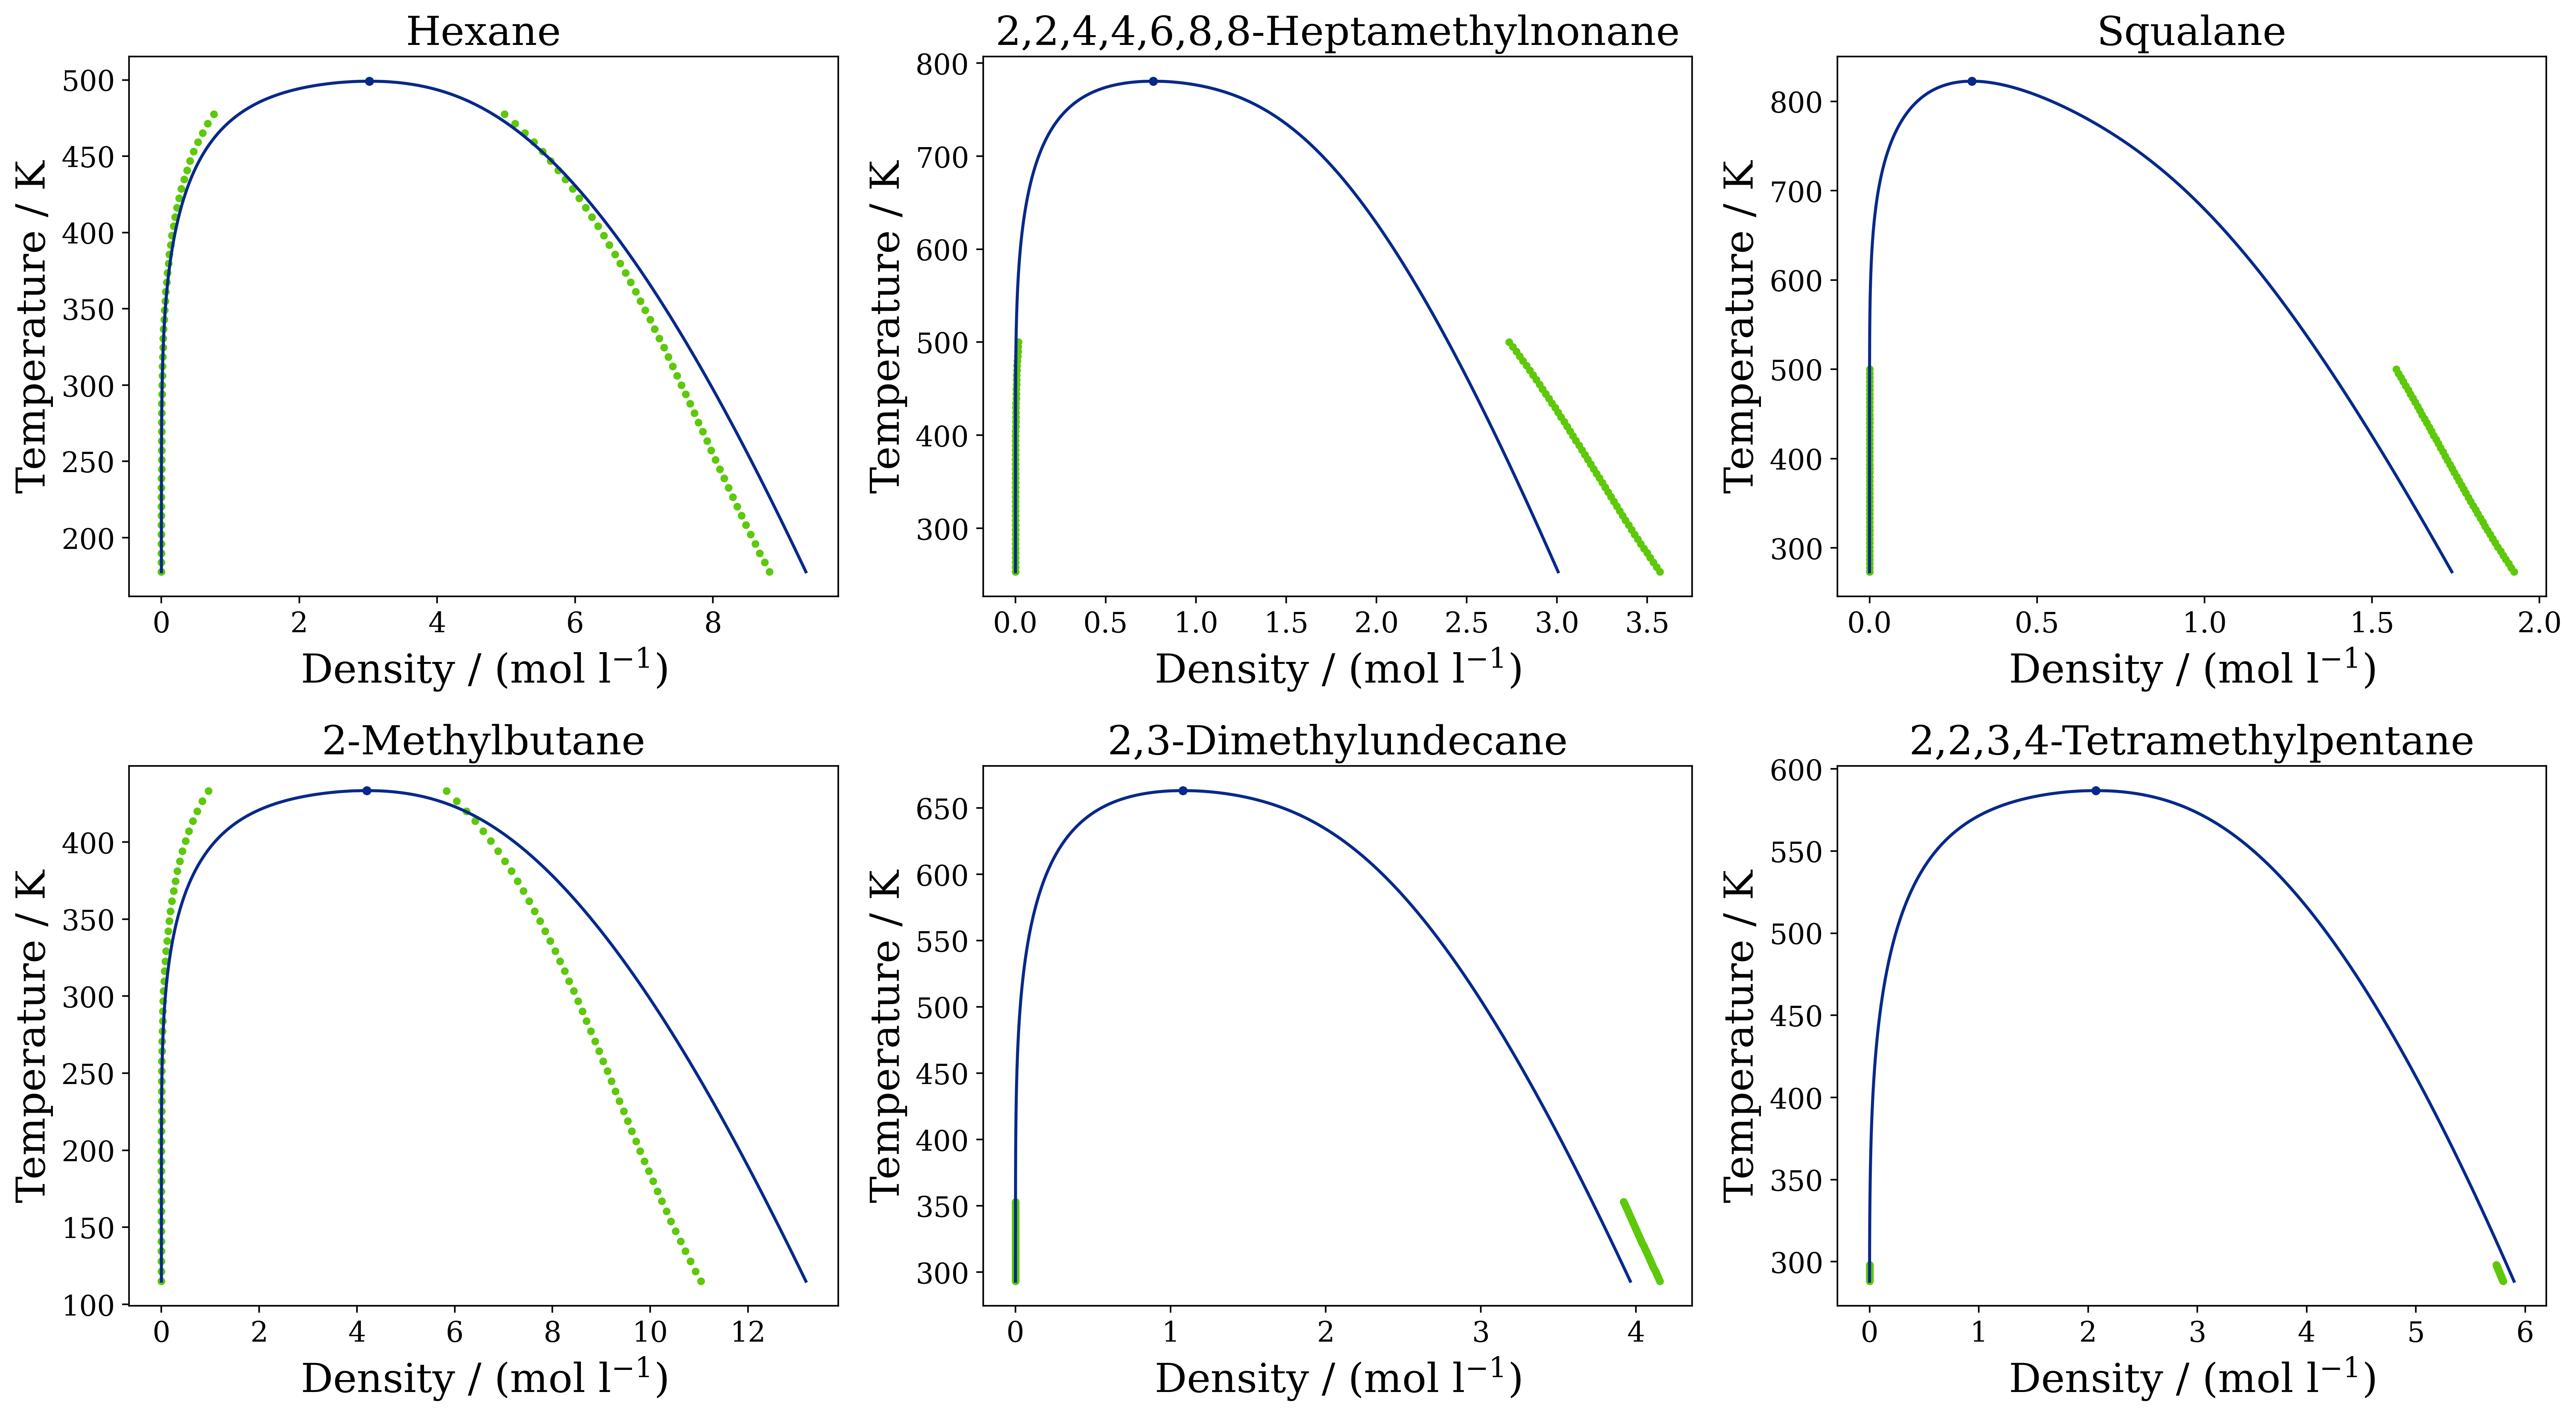

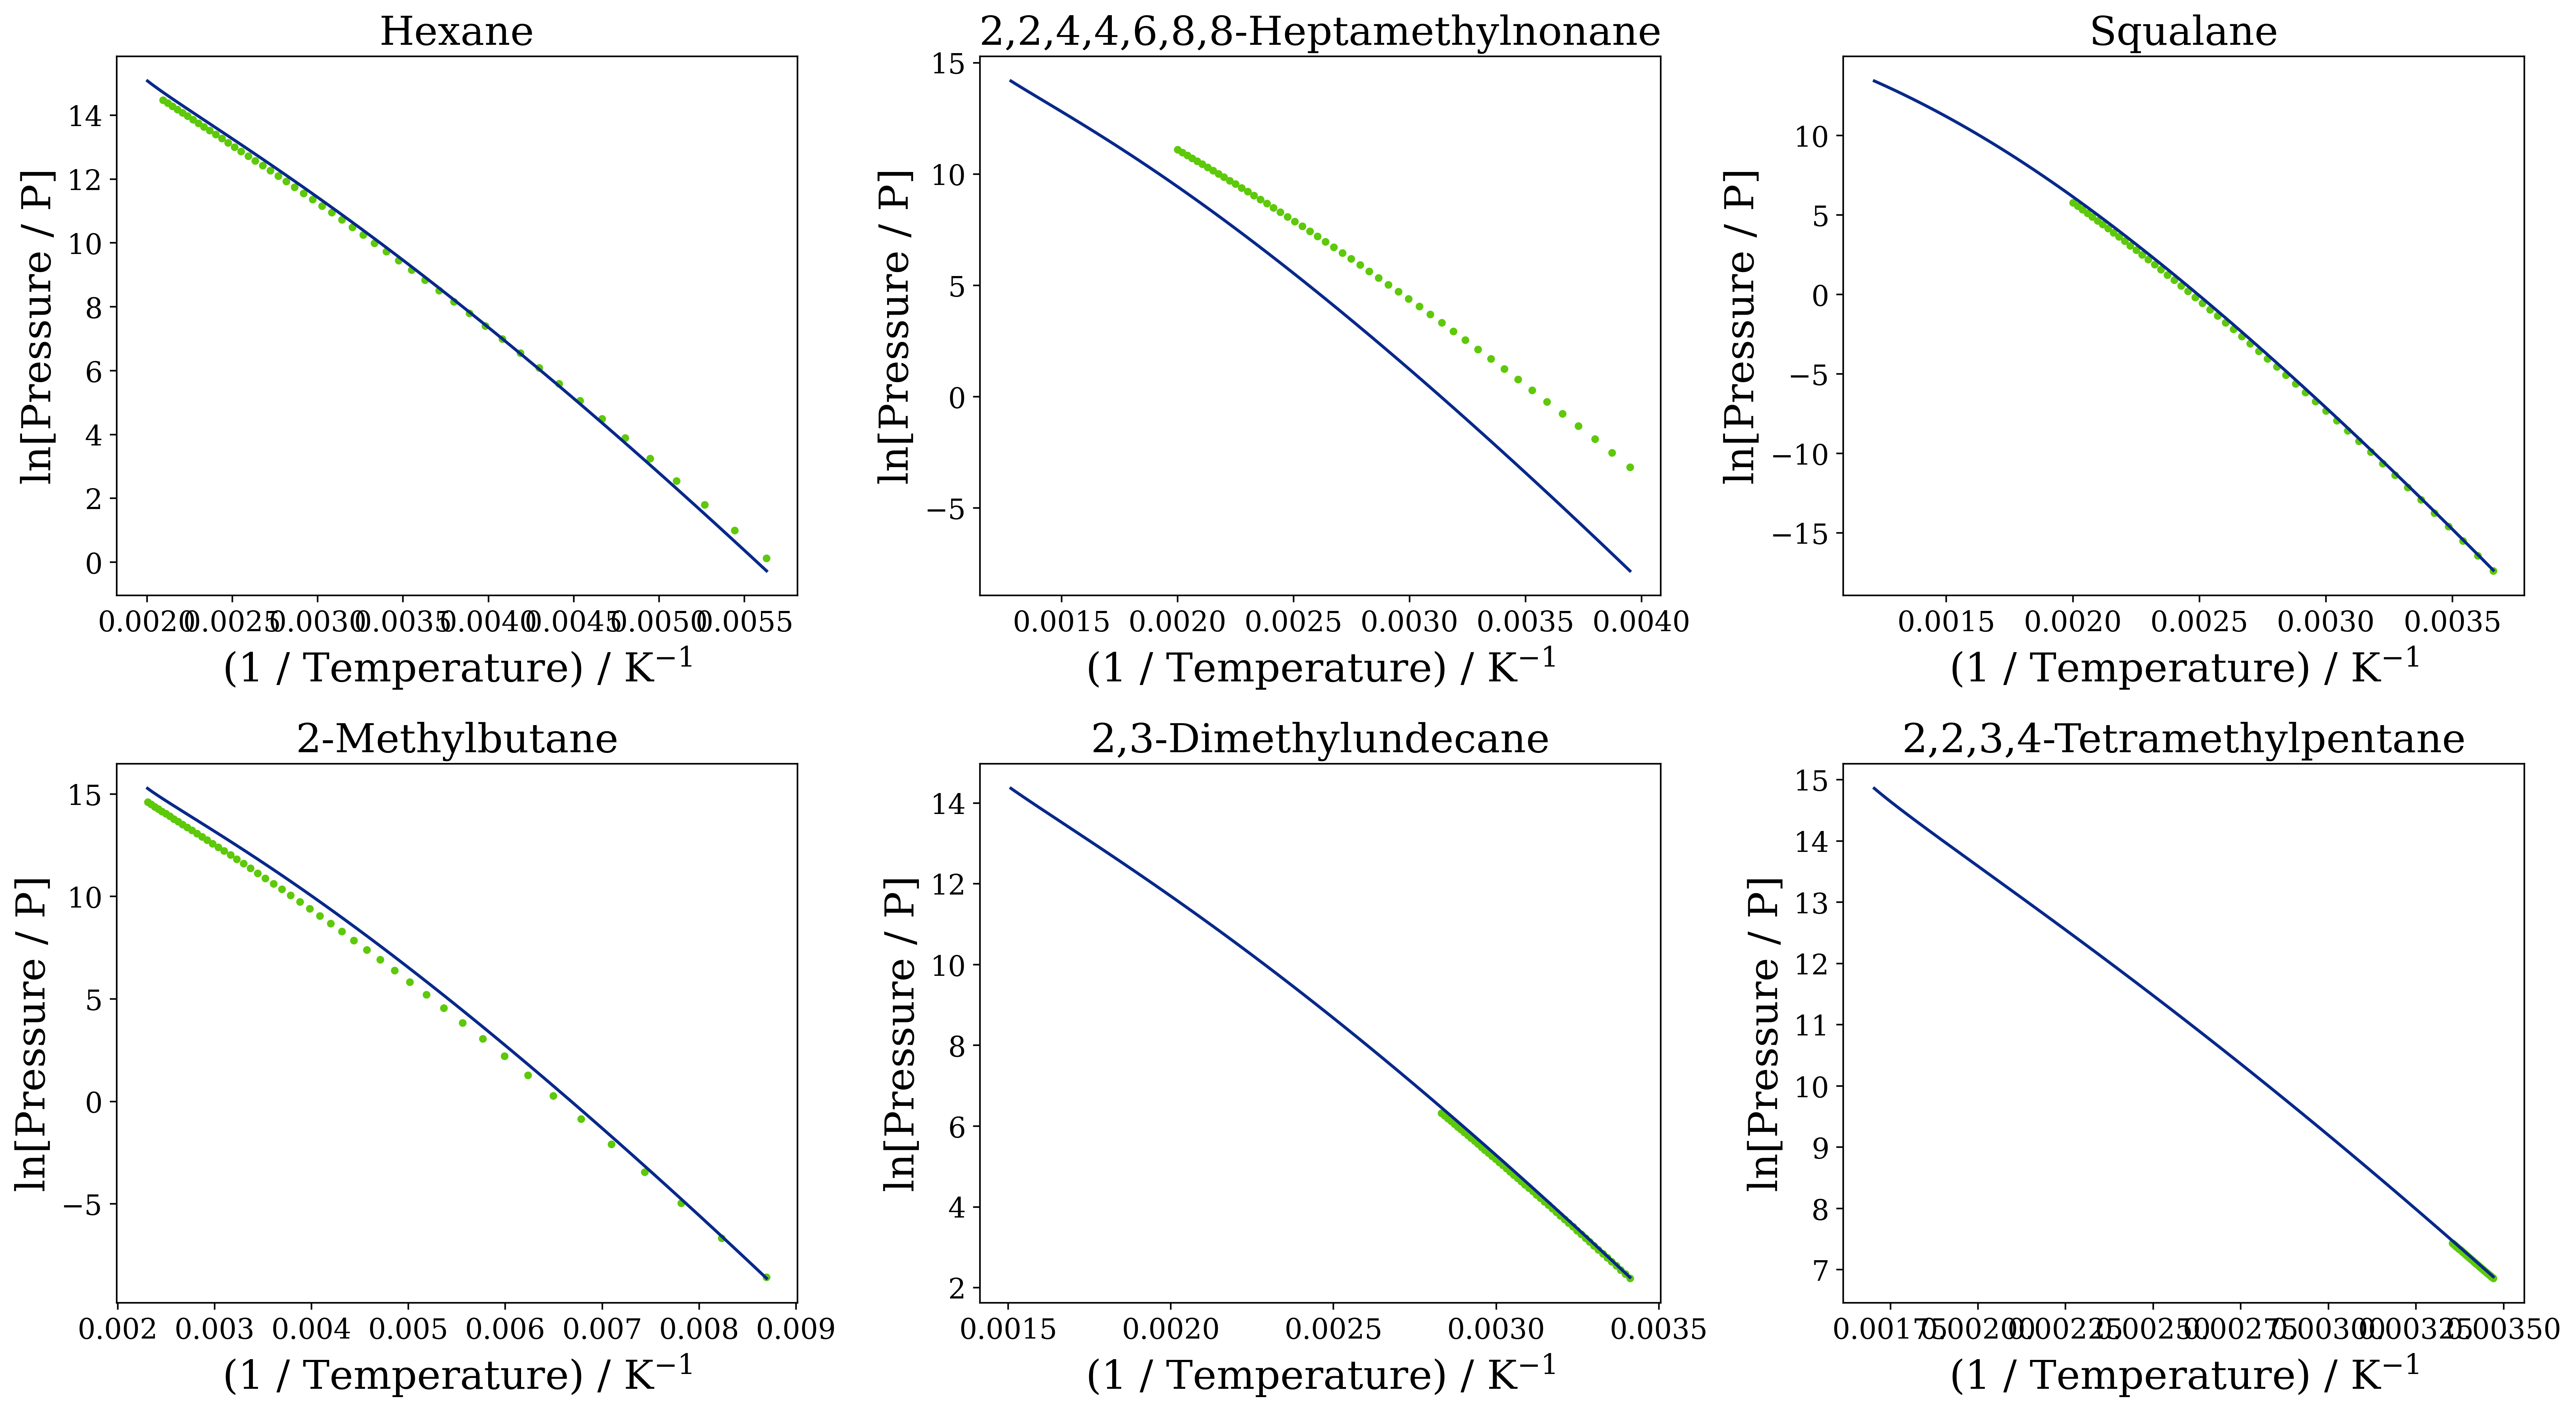

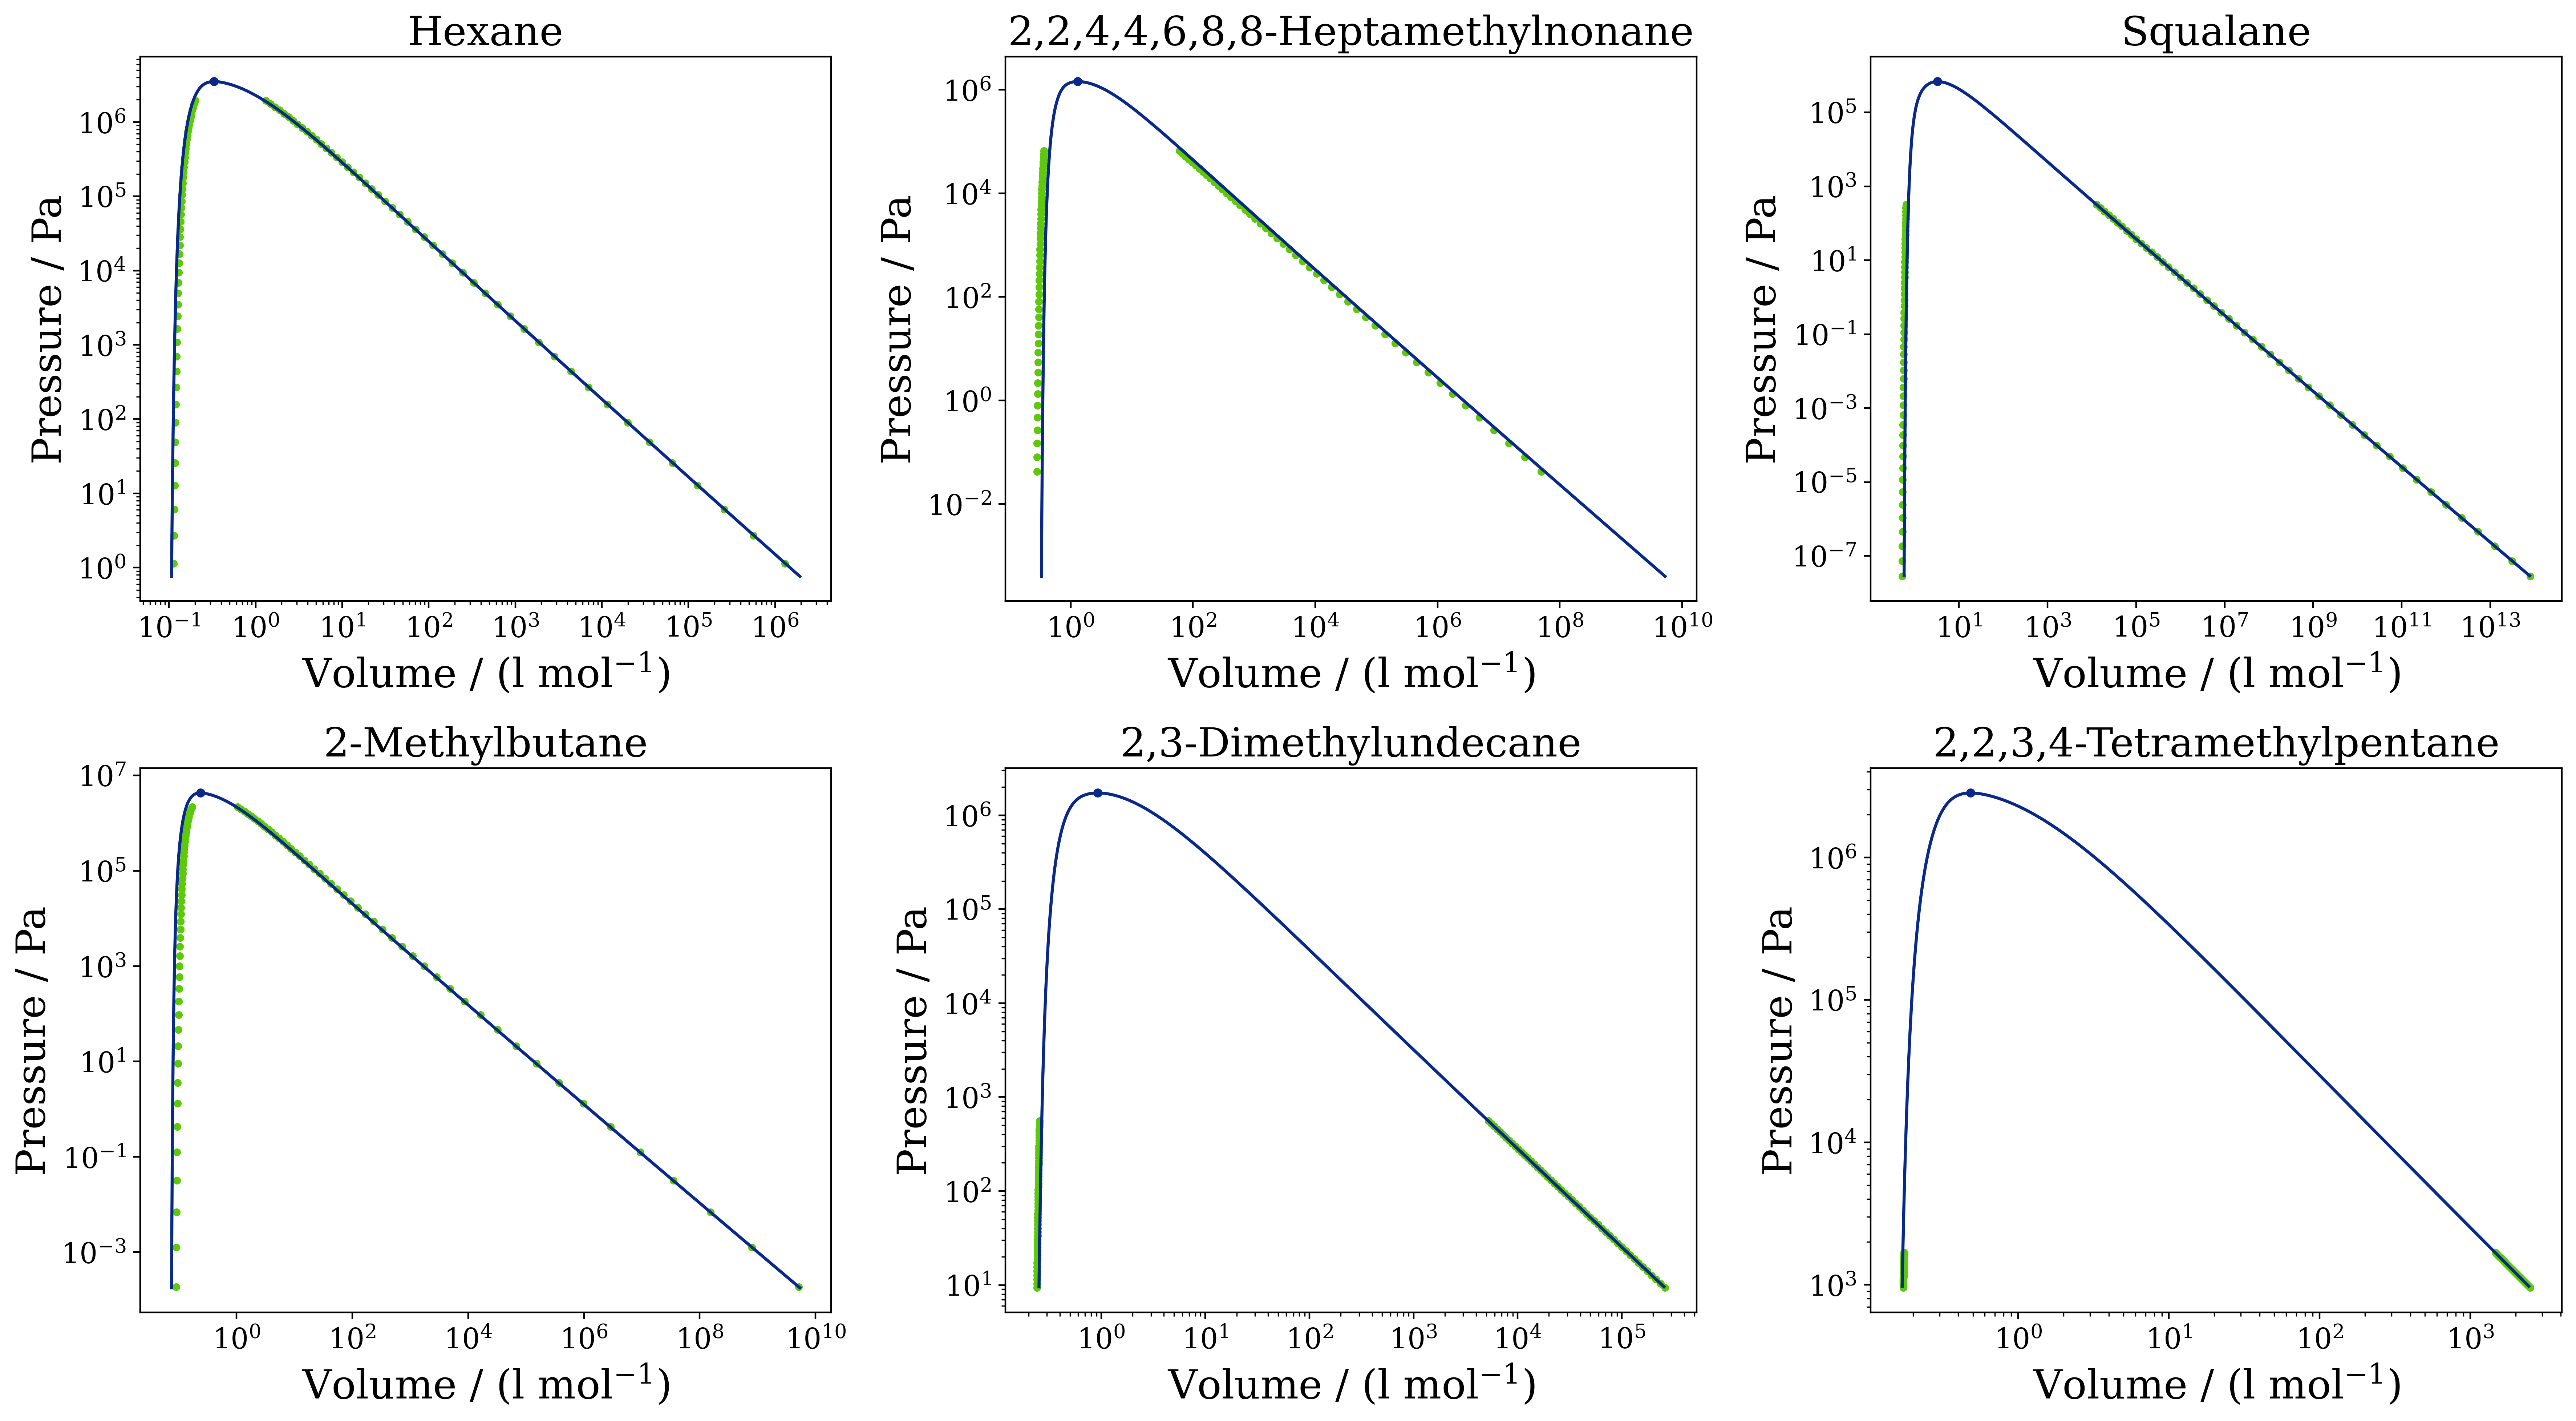

In [49]:
# Plot saturation data for validation set for these species
species = ["Hexane","2,2,4,4,6,8,8-Heptamethylnonane","Squalane","2-Methylbutane","2,3-Dimethylundecane","2,2,3,4-Tetramethylpentane"]

fontsize_label_title = 20
fontsize_ticks = 16

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=14)

# Specify the range and spacing of experimental data to be plotted
plot_all_exptl_data = false
n_points_exptl = 50
same_temp_range = false

# Computed data properties
second_deriv_props_p = 10^5

# Specify vrmie epoch to plot
epoch = length(processed_data_storage[1][!,:m][1])

# Plot line colours
colours = ["#5dc90a","#08298a"] # Experimental, Predicted

figure1, axes_fig_1 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure1.suptitle("Temperature-Density Phase Envelopes", fontsize=24,y=0.95)

figure2, axes_fig_2 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure2.suptitle("Clausius-Clapeyron", fontsize=24,y=0.95)

figure3, axes_fig_3 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure3.suptitle("Pressure-Volume Phase Evnvelopes", fontsize=24,y=0.95)

for i = 1:length(species)

    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species[i]))
    processed_data_split = processed_data_storage[key_i]

    source_data_test_species = filter(row -> row.common_name == lowercase(species[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    if i < 4
        k = 1
        j = i
    else
        k = 2
        j = i - 3
    end

    println(species[i])

    if plot_all_exptl_data == true
        pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
        pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
        pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
    else
        pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
        pcp_T_plot_cc = T_range_pcp
        pcp_P_plot_cc = p_range_pcp
    end

    axes_fig_1[k, j].scatter(pcp_rho_plot, pcp_T_plot_envelope, color="#5dc90a",s=8)
    axes_fig_1[k, j].scatter(1e-3 /vrmie_crits[3], vrmie_crits[1], color="#08298a",s=12)
    axes_fig_1[k, j].plot(1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)), vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie)),color="#08298a")

    axes_fig_1[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_xlabel(L"Density / (mol l$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_ylabel("Temperature / K",fontsize=fontsize_label_title)

    axes_fig_2[k, j].scatter(1 ./pcp_T_plot_cc, log.(pcp_P_plot_cc),color="#5dc90a",s=8)
    axes_fig_2[k, j].plot(1 ./T_range_vrmie, log.(p_range_vrmie),color="#08298a")

    axes_fig_2[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_xlabel(L"(1 / Temperature) / K$\mathregular{^{-1}}$",fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_ylabel("ln[Pressure / P]",fontsize=fontsize_label_title)

    axes_fig_3[k, j].scatter(pcp_v_plot ./ 1e-3, pcp_P_plot_envelope, color="#5dc90a",s=8)
    axes_fig_3[k, j].scatter(vrmie_crits[3]  / 1e-3, vrmie_crits[2], color="#08298a",s=12)
    axes_fig_3[k, j].loglog(vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)) ./ 1e-3, vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie)),color="#08298a")

    axes_fig_3[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_xlabel(L"Volume / (l mol$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_ylabel("Pressure / Pa",fontsize=fontsize_label_title)

end
          
figure1.tight_layout()
figure2.tight_layout()
figure3.tight_layout()


# Useful property setting
# axes_fig_1[k, j].set_xscale("log")
# axes_fig_1[k, j].set_xticks(xticks_pe[i])
# axes_fig_1[k, j].set_xlim([xticks_pe[i][1],xticks_pe[i][end]])
# axes_fig_1[k, j].set_yticks(yticks_pe[i])
# axes_fig_1[k, j].set_ylim([yticks_pe[i][1],yticks_pe[i][end]])


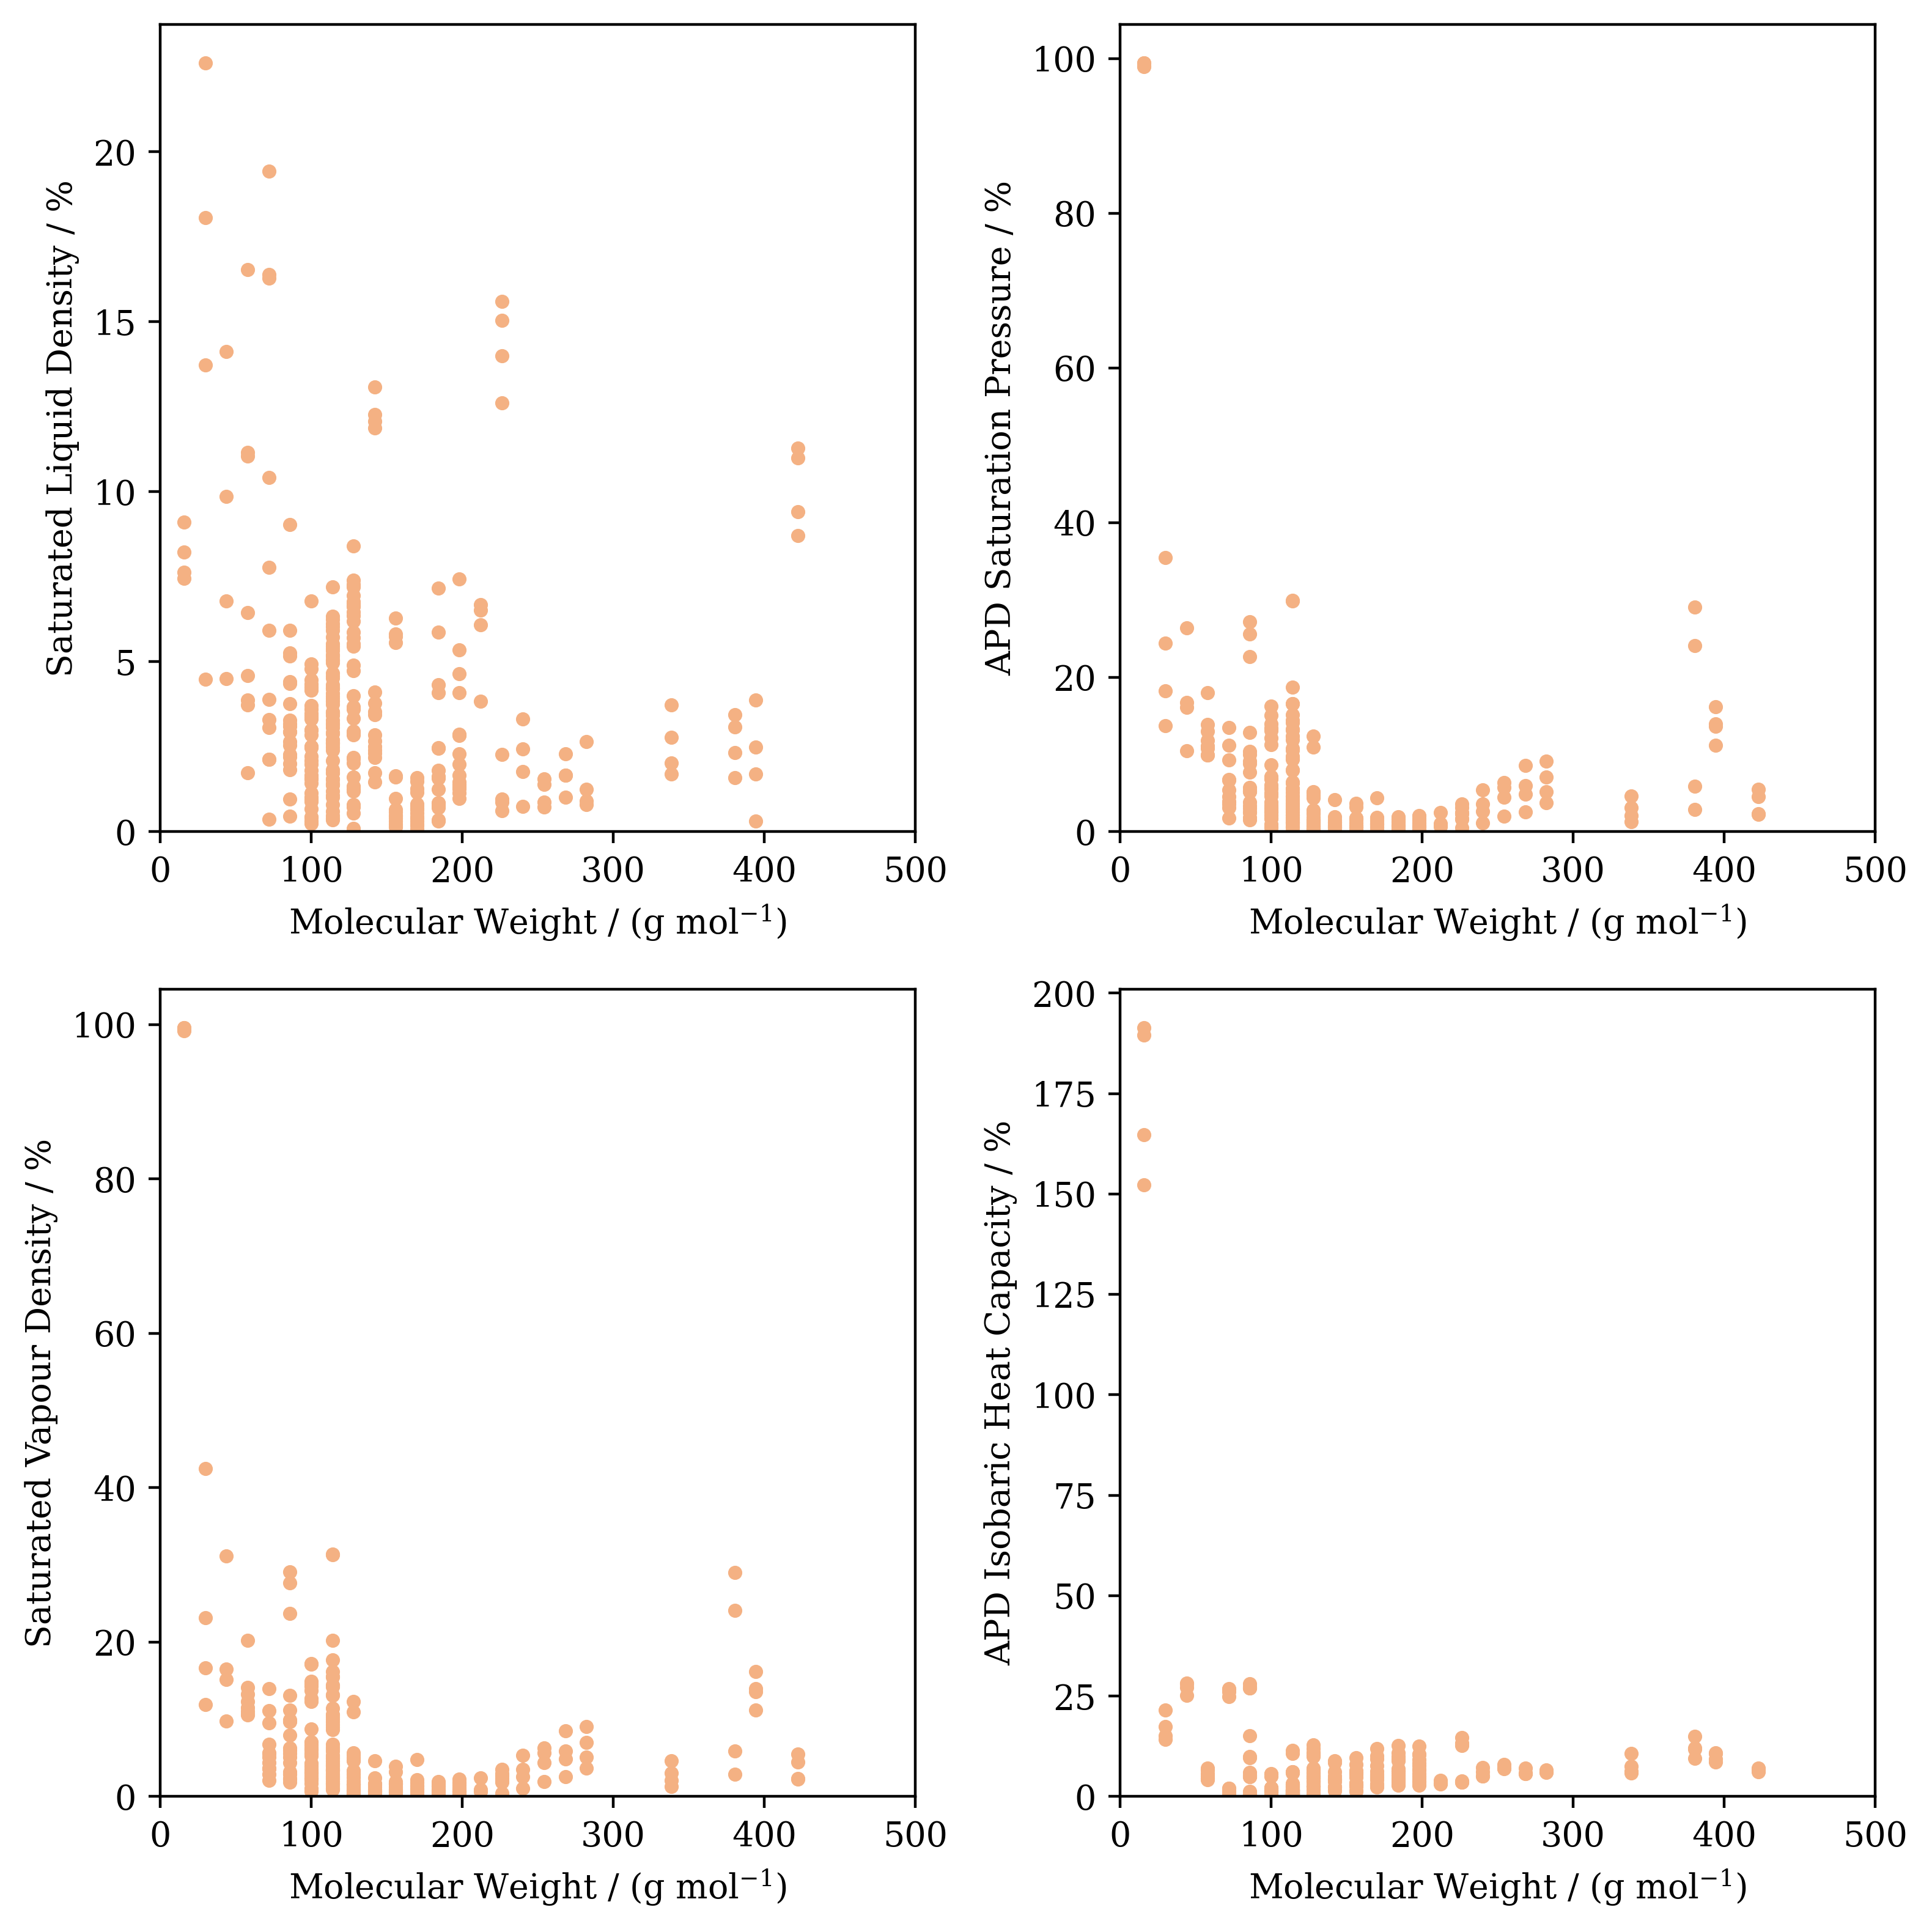

In [86]:
figure_1, axes_1 = plt.subplots(2,2, figsize=(8, 8), dpi=400)

size_points = 10
colour = "#F4B183"

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=10)

axes_1[1].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_rhosat_l,s=size_points,color=colour)
axes_1[2].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_rhosat_v,s=size_points,color=colour)
axes_1[3].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_psat,s=size_points,color=colour)
axes_1[4].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_cp,s=size_points,color=colour)

# axes_1[1].set_ylabel(L"APD Saturated Liquid Density / (mol L$\mathregular{^{-1}}$)")
axes_1[1].set_ylabel("Saturated Liquid Density / %")
axes_1[1].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[1].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[1].set_xlim([0, 500])
axes_1[1].set_ylim([0, nothing])

# axes_1[2].set_ylabel(L"APD Saturated Vapour Density / (mol L$\mathregular{^{-1}}$)")
axes_1[2].set_ylabel("Saturated Vapour Density / %")
axes_1[2].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[2].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[2].set_xlim([0, 500])
axes_1[2].set_ylim([0, nothing])
# axes_1[2].set_yscale("log")

# axes_1[3].set_ylabel("APD Saturation Pressure / Pa")
axes_1[3].set_ylabel("APD Saturation Pressure / %")
axes_1[3].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[3].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[3].set_xlim([0, 500])
axes_1[3].set_ylim([0, nothing])
# axes_1[3].set_yscale("log")

# axes_1[4].set_ylabel(L"APD Isobaric Heat Capacity / ( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)")
axes_1[4].set_ylabel("APD Isobaric Heat Capacity / %")
axes_1[4].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[4].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[4].set_xlim([0, 500])
axes_1[4].set_ylim([0, nothing])

figure_1.tight_layout()

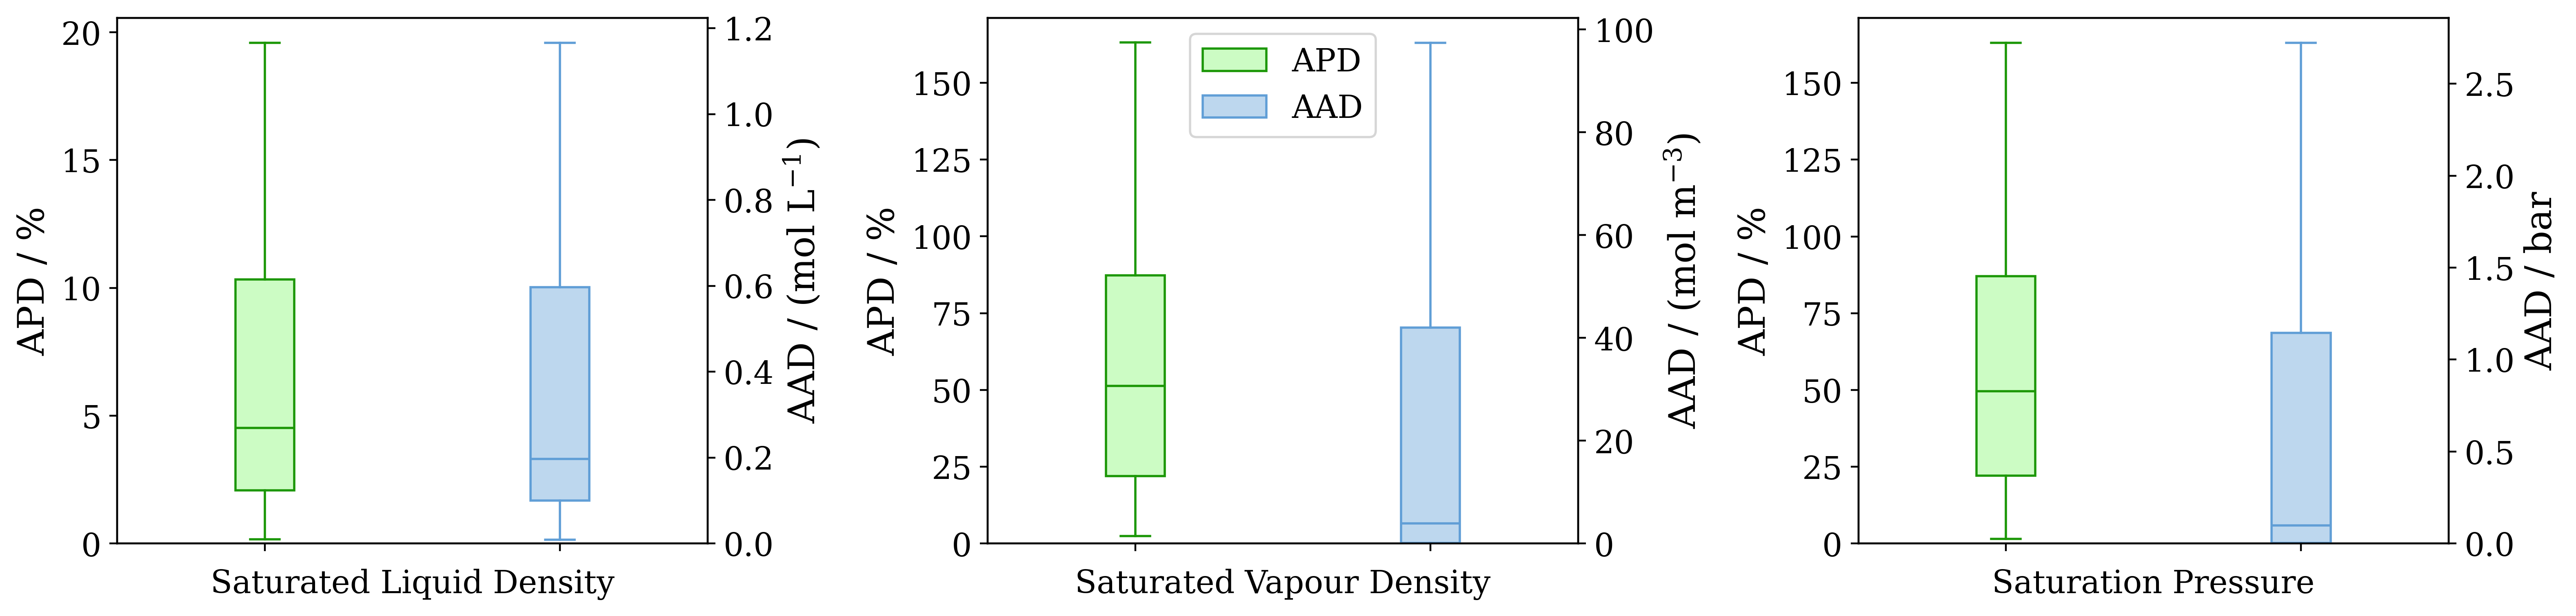

In [12]:
matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=14)

figure_2, axes_2 = plt.subplots(1,3, figsize=(16, 4), dpi=400)

# Green box properties
boxprops1 = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
capprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops1 = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops1 = Dict("color" => "#1C9707")

# Blue box properties
boxprops2 = Dict("linewidth" => 1, "color" => "#609ED6", "facecolor" => "#BDD7EE")  # Add facecolor for box fill
whiskerprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
capprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
flierprops2 = Dict("markerfacecolor" => "#609ED6", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops2 = Dict("color" => "#609ED6")

box_width = 0.2
showfliers = false

cols_AAD = [:AAD_rhosat_l, :AAD_rhosat_v, :AAD_psat]
cols_APD = [:APD_rhosat_l, :APD_rhosat_v, :APD_psat]
properties = ["Saturated Liquid Density","Saturated Vapour Density","Saturation Pressure"]
units = [L"(mol L$\mathregular{^{-1}}$)",L"(mol m$\mathregular{^{-3}}$)","bar"]

for (p, q, i) in zip(cols_AAD, cols_APD, 1:length(cols_AAD))

    abs_dev = val_data_summary_AAD[:, cols_AAD[i]]

    if i == 1
        abs_dev = val_data_summary_AAD[:, cols_AAD[i]] ./10^3
    end

    if i == 3
        abs_dev = val_data_summary_AAD[:, cols_AAD[i]] ./10^5
    end
    
    bp1 = axes_2[i].boxplot(val_data_summary_APD[:, cols_APD[i]], positions=[1], boxprops=boxprops1, whiskerprops=whiskerprops1, capprops=capprops1, flierprops=flierprops1, medianprops=medianprops1, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2[i].set_ylabel("APD / %",fontsize=16)
    axes_2[i].set_xticklabels("")
    axes_2[i].set_ylim([0, nothing])
    axes_2[i].set_xlabel(properties[i])

    axes_2_1_2 = axes_2[i].twinx()
    bp2 = axes_2_1_2.boxplot(abs_dev, positions=[2], boxprops=boxprops2, whiskerprops=whiskerprops2, capprops=capprops2, flierprops=flierprops2, medianprops=medianprops2, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2_1_2.set_ylabel("AAD / $(units[i])",fontsize=16)
    axes_2_1_2.set_xticklabels("")
    axes_2_1_2.set_ylim([0, nothing])

    if i == 2
        axes_2[i].legend([bp1["boxes"][1], bp2["boxes"][1]], ["APD", "AAD"], loc="upper center")
    end   

end

figure_2.tight_layout()

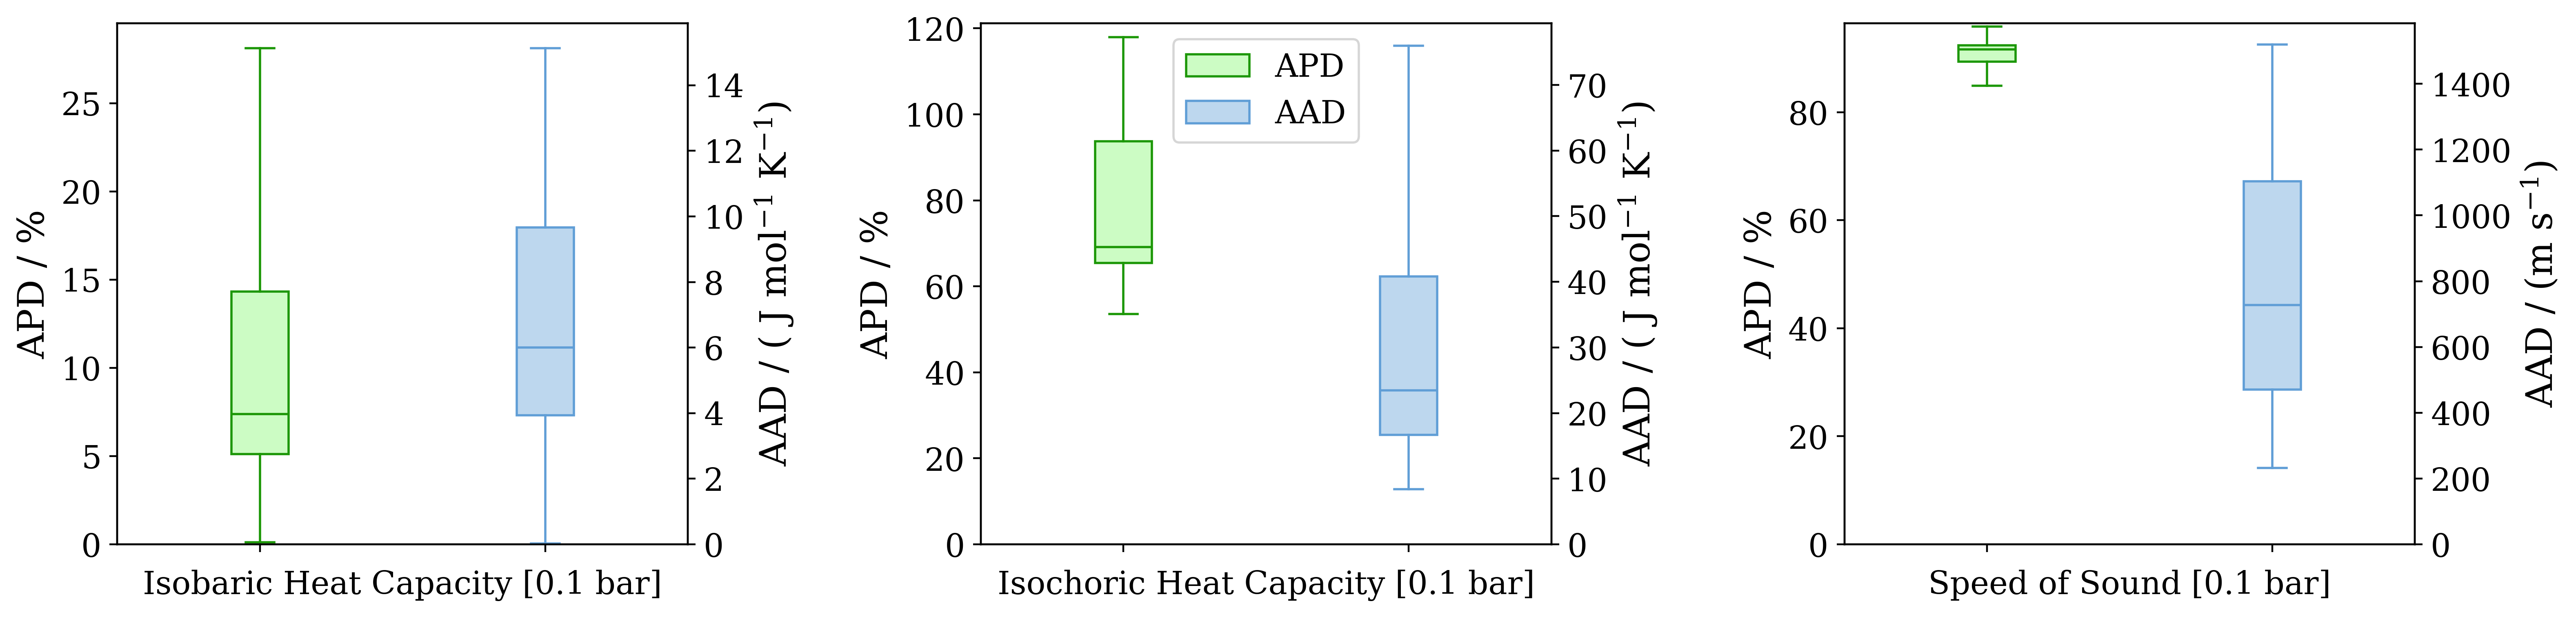

In [11]:
subplot_rows = 1
subplot_cols = 3

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=14)

figure_2, axes_2 = plt.subplots(subplot_rows,subplot_cols, figsize=(16, 4), dpi=400)

# Green box properties
boxprops1 = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
capprops1 = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops1 = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops1 = Dict("color" => "#1C9707")

# Blue box properties
boxprops2 = Dict("linewidth" => 1, "color" => "#609ED6", "facecolor" => "#BDD7EE")  # Add facecolor for box fill
whiskerprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
capprops2 = Dict("linewidth" => 1, "color" => "#609ED6")
flierprops2 = Dict("markerfacecolor" => "#609ED6", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops2 = Dict("color" => "#609ED6")

box_width = 0.2
showfliers = false

cols_AAD = [:AAD_cp, :AAD_cv, :AAD_speed_sound]
cols_APD = [:APD_cp, :APD_cv, :APD_speed_sound]
properties = ["Isobaric Heat Capacity [0.1 bar]", "Isochoric Heat Capacity [0.1 bar]", "Speed of Sound [0.1 bar]"]
units = [L"( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)", L"( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)", L"(m s$\mathregular{^{-1}}$)"]

for (p, q, i) in zip(cols_AAD, cols_APD, 1:length(cols_AAD))

    abs_dev = val_data_summary_AAD[:, cols_AAD[i]]
    
    bp1 = axes_2[i].boxplot(val_data_summary_APD[:, cols_APD[i]], positions=[1], boxprops=boxprops1, whiskerprops=whiskerprops1, capprops=capprops1, flierprops=flierprops1, medianprops=medianprops1, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2[i].set_ylabel("APD / %",fontsize=16)
    axes_2[i].set_xticklabels("")
    axes_2[i].set_ylim([0, nothing])
    axes_2[i].set_xlabel(properties[i])

    axes_2_1_2 = axes_2[i].twinx()
    bp2 = axes_2_1_2.boxplot(abs_dev, positions=[2], boxprops=boxprops2, whiskerprops=whiskerprops2, capprops=capprops2, flierprops=flierprops2, medianprops=medianprops2, patch_artist=true, widths=box_width,showfliers=showfliers)
    axes_2_1_2.set_ylabel("AAD / $(units[i])",fontsize=16)
    axes_2_1_2.set_xticklabels("")
    axes_2_1_2.set_ylim([0, nothing])

    if i == 2
        axes_2[i].legend([bp1["boxes"][1], bp2["boxes"][1]], ["APD", "AAD"], loc="upper center")
    end   

end

figure_2.tight_layout()

In [13]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
processed_data_lin_alkanes = [filter(row -> contains_only_c(row.isomeric_SMILES), i) for i in processed_data_storage]
processed_data_lin_alkanes = sort.(processed_data_lin_alkanes, :Mw);

In [34]:
processed_data_lin_alkanes

5-element Vector{DataFrame}:
 6×9 DataFrame
 Row │ species     isomeric_SMILES       Mw       m                            ⋯
     │ String31    String                Float64  Array…                       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ methane     C                      16.031  [1.83071, 1.83207, 1.8334, 1 ⋯
   2 │ heptane     CCCCCCC               100.125  [3.36084, 3.37138, 3.38133,
   3 │ decane      CCCCCCCCCC            142.172  [4.24211, 4.25647, 4.27011,
   4 │ dodecane    CCCCCCCCCCCC          170.203  [5.25417, 5.2718, 5.28866, 5
   5 │ hexadecane  CCCCCCCCCCCCCCCC      226.266  [7.21346, 7.23716, 7.25989,  ⋯
   6 │ eicosane    CCCCCCCCCCCCCCCCCCCC  282.329  [9.05971, 9.08946, 9.11746,
                                                               6 columns omitted
 2×9 DataFrame
 Row │ species      isomeric_SMILES           Mw       m                       ⋯
     │ String31     String                    Float64  Array…

23
23
0.9835346843989706
0.9929672354343008


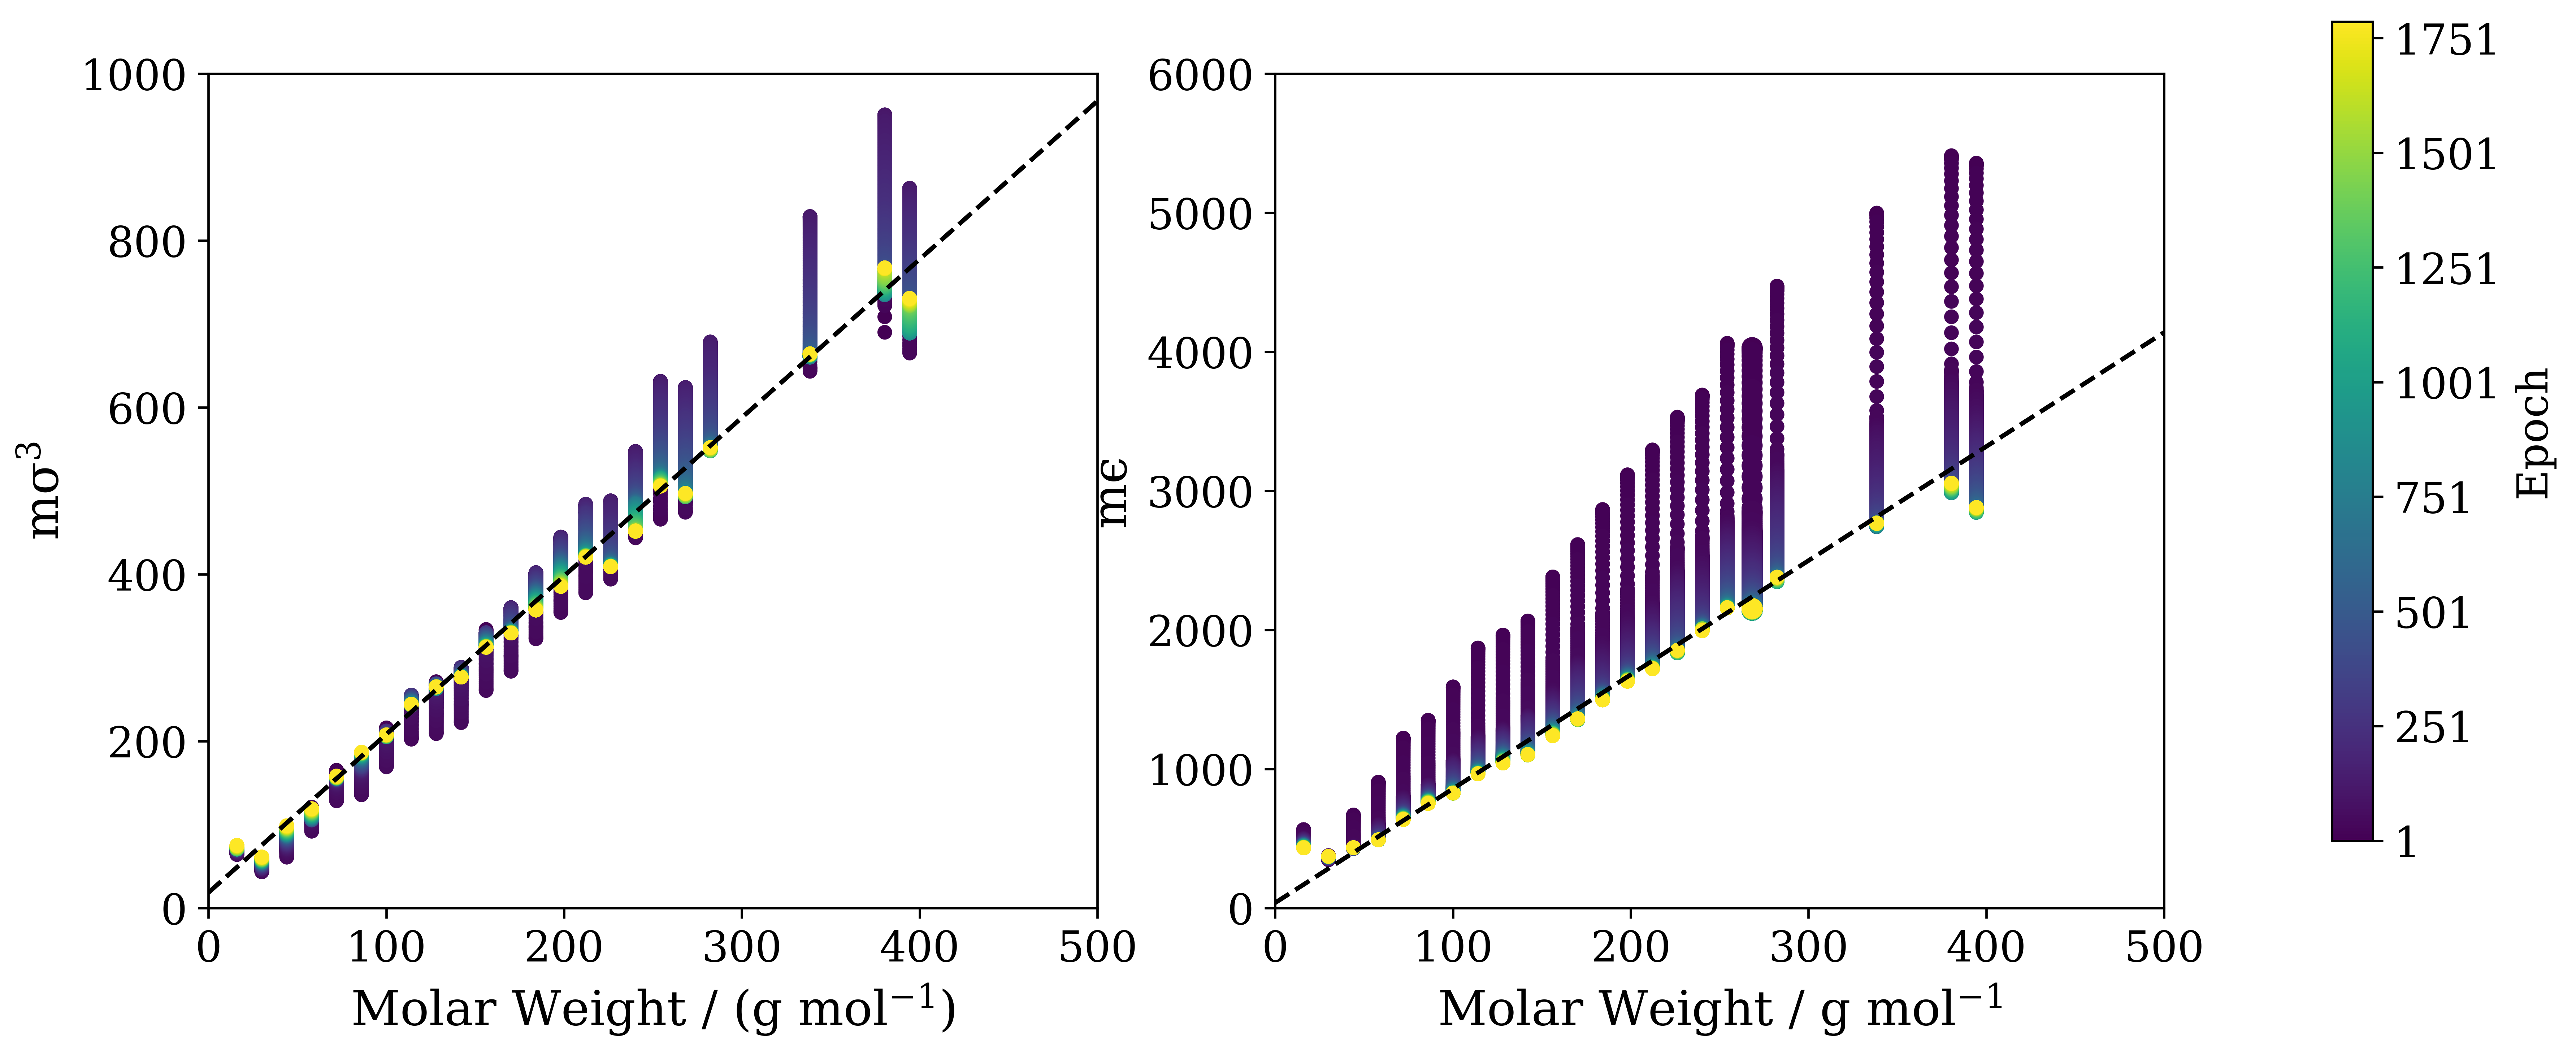

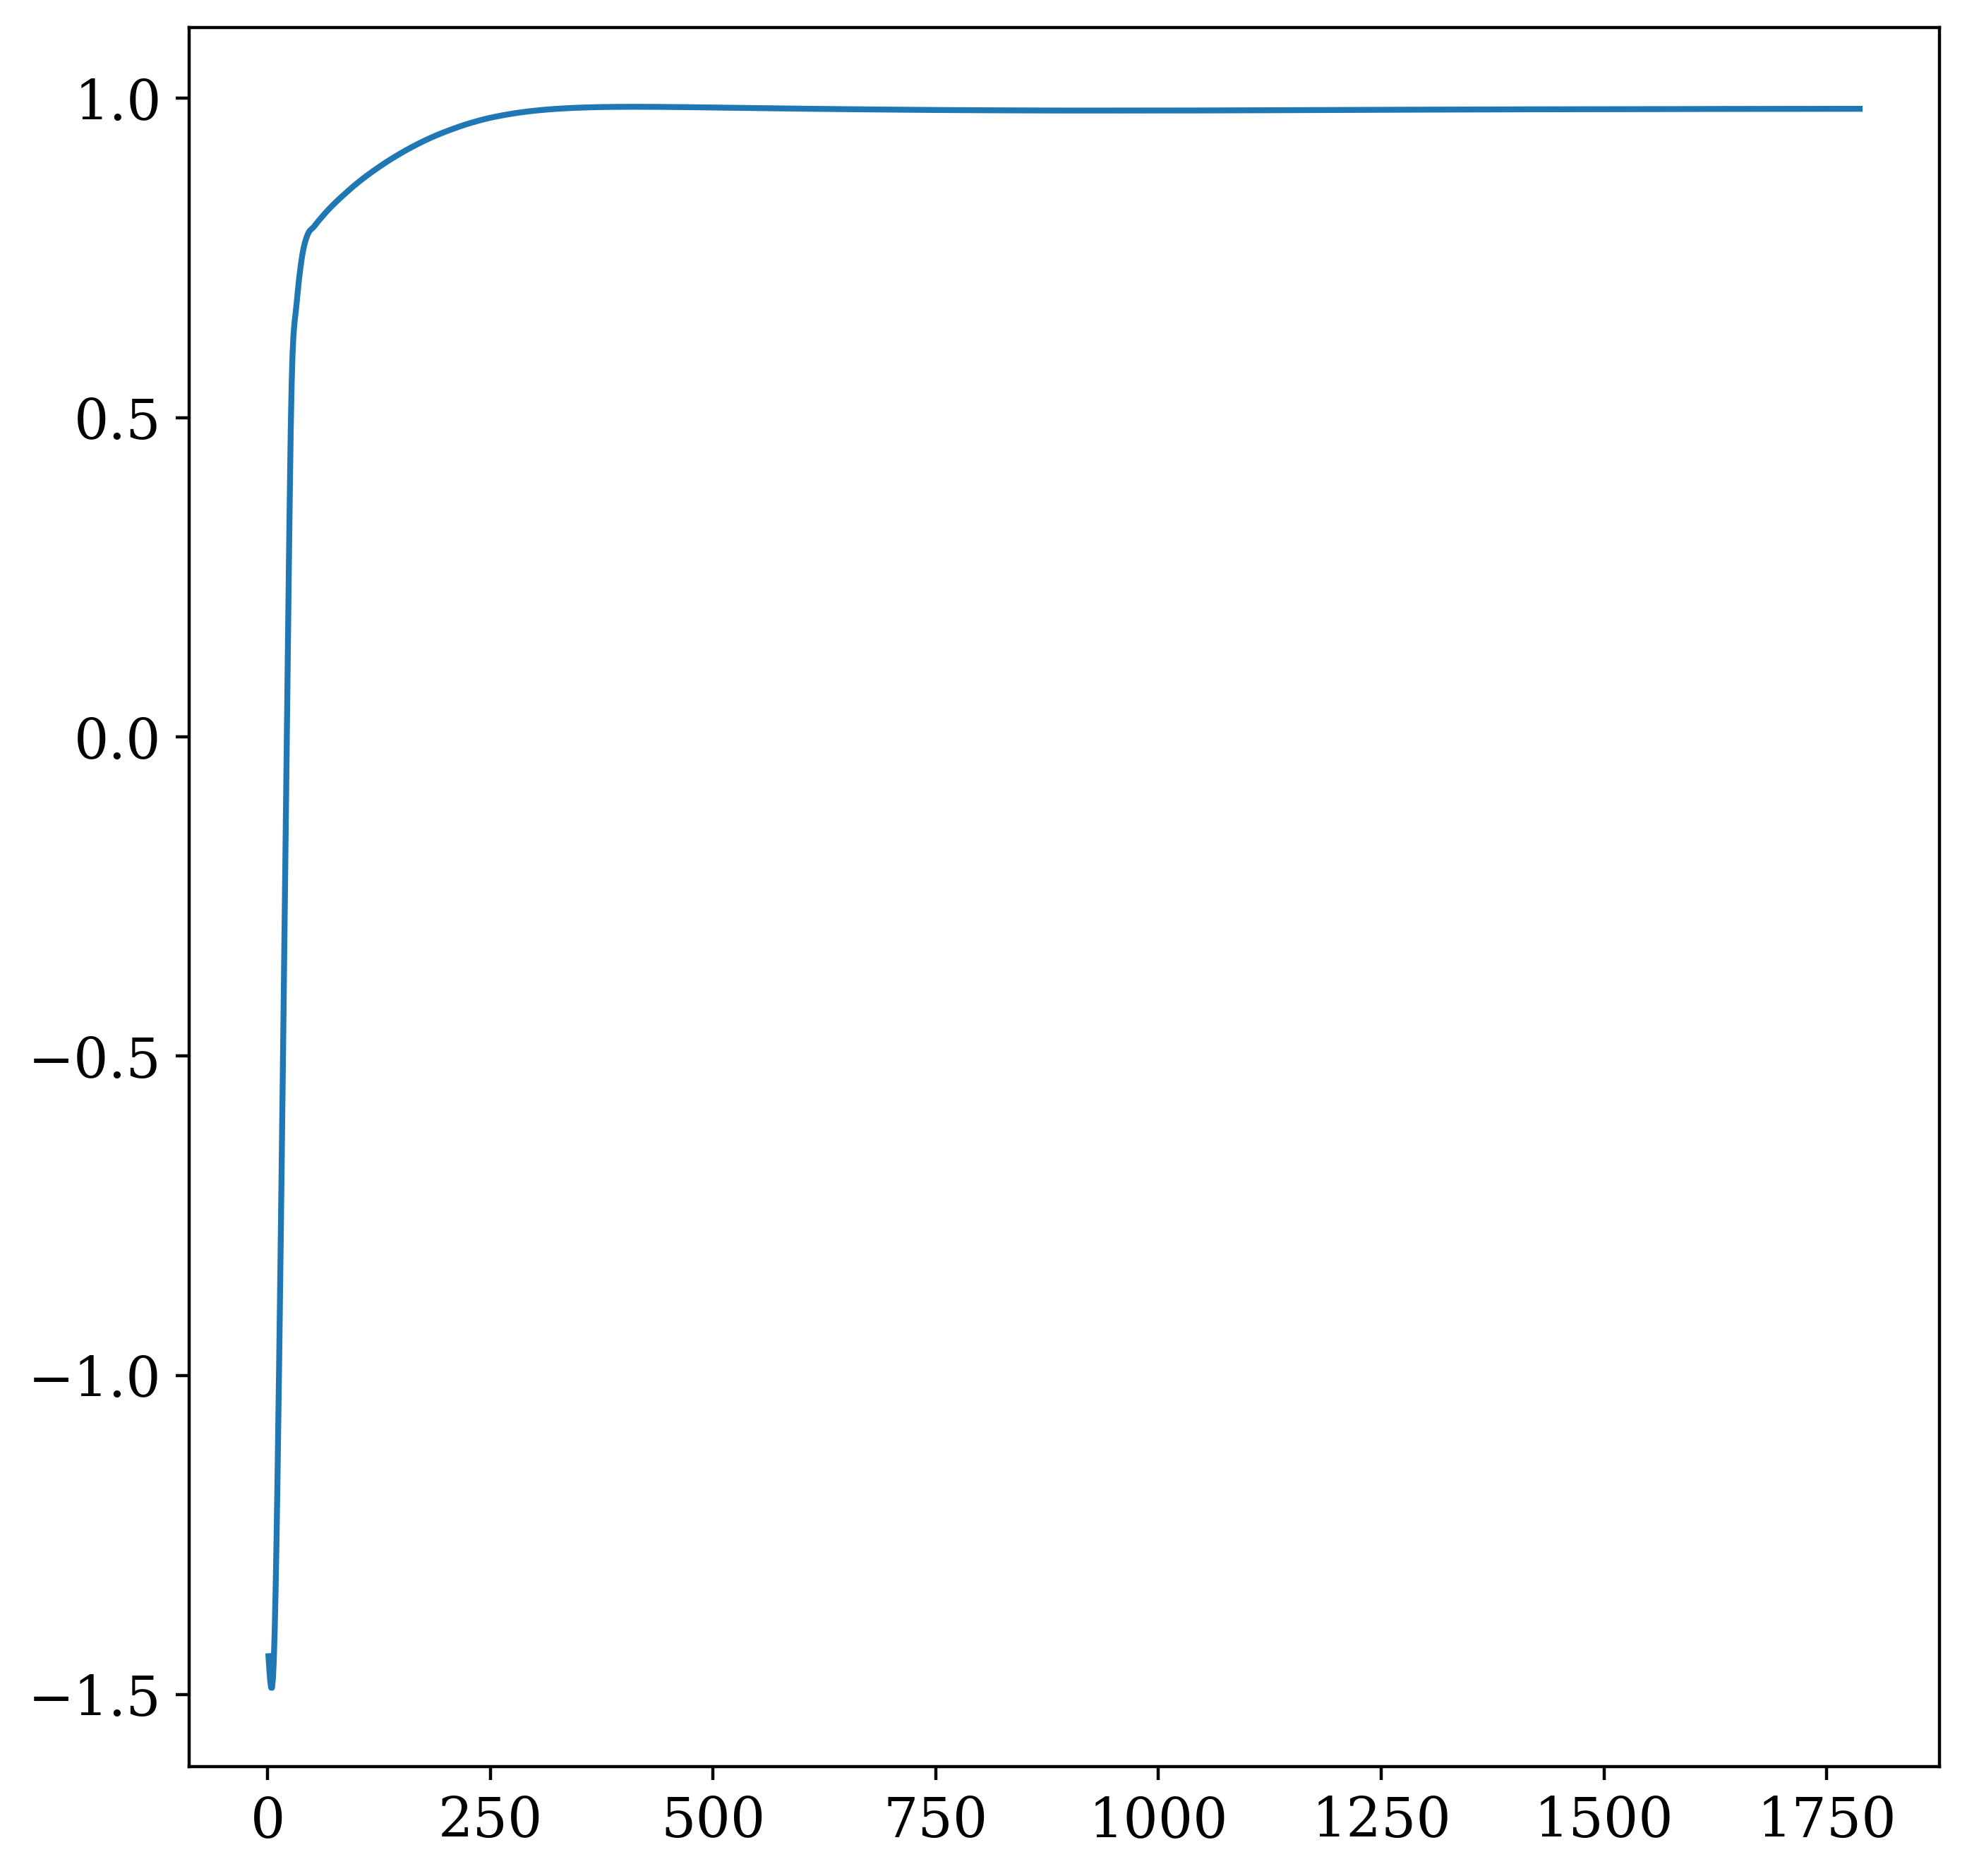

In [63]:
epoch = 1787 # min(total_epochs) (shortest of all five folds), true (max length each fold)

analyse_training == false
vmin = 1
vmax = epoch

colour_bar_interval = 250
colour_scheme = "viridis"
scatter_plot_size = 15
label_fontsize = 16

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=14)

species_list = string.(vcat(collect(processed_data_lin_alkanes[i][!,:species] for i = 1:length(files_to_average))...))

figure_1, axes_1 = plt.subplots(1, 3, figsize=(18, 5), dpi=600)
# figure_1.suptitle("Parameter Evolution for Linear Alkanes", fontsize=18, x = 0.38, y=0.975)

color_mapping = collect(range(vmin, vmax))
ideal_Mw = collect(range(0, 500, epoch))

ideal_mσ3s = [1.8975 * i + 18.278 for i in ideal_Mw]
ideal_mϵs = [8.2034 * i + 36.245 for i in ideal_Mw]

axes_1[1].plot(ideal_Mw, ideal_mσ3s, color="k", "--")
axes_1[2].plot(ideal_Mw, ideal_mϵs, color="k", "--")

Mw = [] ; mϵ = [] ; species_name = [] ; ms = [] ; σs = []; ϵs = []; λ_rs = []; mϵs = []; mσ3s = []; MWs = []

for i = 1:length(species_list)

    if analyse_training == true
        processed_data_split = processed_data_lin_alkanes[Int(floor((i-1)/64) + 1)]
    else
    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species_list[i]))
    processed_data_split = processed_data_lin_alkanes[key_i]
    end

    processed_data_split = filter(row -> row.species == species_list[i], processed_data_split)

    if epoch == true
        epoch = length(processed_data_lin_alkanes[j][1,:m])
    end
    
    Mw = fill(processed_data_split[1,:Mw], epoch)
    ms = processed_data_split[1,:m]
    σs = processed_data_split[1,:σ]
    ϵs = processed_data_split[1,:ϵ]
    λ_rs = processed_data_split[1,:λ_r]
    λ_as = 6

    mσ3 = [ms[i] * σs[i]^3 for i in 1:epoch]
    mϵ = [ms[i]^1 * ϵs[i] for i in 1:epoch]

    vdw_as = [-2*pi * ((λ_rs[i]/(λ_rs[i] - λ_as))*(λ_rs[i]/λ_as)^(λ_as/(λ_rs[i]-λ_as))) * (ϵs[i] * σs[i]^3 * ms[i]^1 * (1/(λ_rs[i] - 3) - 1/(λ_as-3))) for i in 1:epoch]

    axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)
    axes_1[1].scatter(Mw, mσ3, c=color_mapping, cmap=colour_scheme,s=scatter_plot_size,vmin=vmin,vmax=vmax)

    push!(mσ3s, mσ3)
    push!(mϵs, mϵ)
    push!(MWs, processed_data_split[1,:Mw])

end

# Plot 1 details
axes_1[1].set_xlabel(L"Molar Weight / (g mol$\mathregular{^{-1}}$)", fontsize=label_fontsize)
axes_1[1].set_ylabel(L"mσ$\mathregular{^3}$", fontsize=label_fontsize)
axes_1[1].set_ylim([0, 1000])
axes_1[1].set_xlim([0, 500])

# Find source paper for clapeyron saft-vr-mie params
# axes_1[2].legend(["Lafitte et al. (2013), Hosseinifar et al. (2016)","Current Fit"], loc="lower right", fontsize=8)
axes_1[2].set_xlabel(L"Molar Weight / g mol$\mathregular{^{-1}}$", fontsize=label_fontsize)
axes_1[2].set_ylabel("mϵ", fontsize=label_fontsize)
axes_1[2].set_ylim([0, 6000])
axes_1[2].set_xlim([0, 500])

cax = figure_1.add_axes([0.61, 0.05, 0.07, 1])
cbar = figure_1.colorbar(axes_1[2].scatter(Mw, mϵ, c=color_mapping, cmap=colour_scheme), ax=cax, ticks=vmin:colour_bar_interval:vmax, label="Epoch")
plt.delaxes(cax)
plt.delaxes(axes_1[3])

println(length(mσ3s))
println(length(mϵs))

mϵs_restruc = [[mϵs[j][i] for j = 1:length(species_list)] for i = 1:epoch]
mσ3_restruc = [[mσ3s[j][i] for j = 1:length(species_list)] for i = 1:epoch]

mϵ_pred_r2 = [8.2034 * i + 36.245 for i in MWs]
mσ3_pred_r2 = [1.8975 * i + 18.278 for i in MWs]

r2mϵ = [r_squared(y_actual = mϵ_pred_r2, y_predicted = mϵs_restruc[i]) for i = 1:epoch]
r2mσ3 = [r_squared(y_actual = mσ3_pred_r2, y_predicted = mσ3_restruc[i]) for i = 1:epoch]#

plt.figure(figsize=(8, 8), dpi=400)

plt.plot(range(1,epoch), r2mϵ)


# To save the figure
# plt.savefig("all_compound_phase_envelopes.png", dpi=400)

println(r2mϵ[end])
println(r2mσ3[end])
# println(ideal_mϵs_restruc)